                                                                   Helga Sigríður Thordersen Magnúsdóttir s202027 
                                                                                 Hlynur Árni Sigurjónsson s192302
                                                                             Katrín Erla Bergsveinsdóttir s202026
                                                                                Kristín Björk Lilliendahl s192296
 
 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<img src="https://susfans.eu/sites/default/files/clients/DTU.png"  align="right" width="300"/>

# Business Question 2 - Market Analysis

**<font color='red'>In order for all the figures to show up the notebook needs to be trusted: File -> Trust notebook</font>**
### Where should we open up a new Pizza place, who should we invite to the opening and what should we keep in mind?


We will continue to work as consultants for a company that wants to open a pizza restaurant in Copenhagen. From Business Question 1, we now know what people like about pizza restaurants, what customers' favorite features about the restaurants are and what they complain about. Further text analysis has been performed and we will build on those findings. 

In this business question we will focus on generating a detailed market analysis of the Pizza market in Copenhagen, to be able to answer the business question: **Where should we open up a new Pizza place, who should we invite to the opening and what should we keep in mind?** First the scope of the market will be defined in a broader sense, to include all restaurants that offer pizzas. We will gather additional data about the different areas (neighbourhoods) in Copenhagen, and use that to visualize the distribution and evoluation of pizza places. The popularity of the pizza places will be estimated and the reviews of each place will be used to generate both TF-IDF and Sentiment for each place. Those will then be used to evaluate the differences between the pizza places in different areas. A network of the market and the reviewers will be generated in hopes of gaining insights into the relationship between restaurants and reviewers. Based on those networks, the most influential reviewers will be identified to compile a short list of influencers that could be invited to a grand opening.

Some of the market questions answered include:

* Who are the players in the market? Are they only Pizzerias?
* What are the popular places doing differently?
* Where are the restaurants located?
* How has the market developed?
* Where should you open up a pizza place?
* Who should you invite to the opening of the new pizza place?

Finally a recommendation will be made on where a new Pizza place should be opened, who should be invited to the opening and what should be kept in mind before opening the place.


## Contents
* [1 Gather data](#data)
* [2 Data exploration and enrichment](#enrich)
    * [2.1 Location data](#location)
    * [2.2 Review text clean up](#clean_text)
    * [2.3 Find all Pizza restaurants](#pizza)
    * [2.4 Review Sentiment](#sentiment) 
    * [2.5 Opening date/Closing date](#openclose)
    * [2.6 Estimators for popularity](#popularity)
* [3 Market analysis](#market)
    * [3.1 Cousine Types](#cousine)
    * [3.2 Where are the pizza restaurants located?](#pizza_loc)
    * [3.3 Differences between areas (neighbourhoods)](#diff_areas)
    * [3.4 Evolution of distribution of pizza places](#heatmap)
    * [3.5 Restaurant density](#density)
    * [3.6 Restaurant density development](#density_development)
    * [3.7 TF-IDF of review scores - What matters for a high review?](#tf-idf-reviews)
    * [3.8 TF-IDF of popular pizzerias - What matters for popularity?](#popular_wordcloud)
    * [3.9 Network analysis](#network)
* [4 Conclusions and Discussions](#conclusions)

<hr>

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Imported data 🐼 
The first step as always is to install and import the necessary packages.

In [1]:
# !pip install pandas_profiling
# !pip install folium
# !pip install -U selenium
# !pip install --upgrade pip
# !pip install fa2

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas_profiling import ProfileReport
import requests
import urllib.parse
import folium
import geopandas as gpd
import json
from datetime import datetime
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import nltk
import requests 
from bs4 import BeautifulSoup
import csv 
from selenium import webdriver
import time
import sys
import os
import argparse
import string
import pickle
import datetime as dt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from folium import plugins
from folium.plugins import HeatMap
from fa2 import ForceAtlas2
import copy
import math
import random
import networkx as nx
from wordcloud import WordCloud, ImageColorGenerator
from operator import itemgetter

In [3]:
# Download necessary resources from the nltk package
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('vader_lexicon');

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristinbjorklilliendahl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristinbjorklilliendahl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kristinbjorklilliendahl/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<a id='data'></a>
# 1. Gather data 🇩🇰
The first step is as always to gather the data needed to perform the analysis. The data was prepared and pickled in the **Milestone 1** notebook for further data analysis. Let's start by reading those in.

In [4]:
# Read data from pickled files
restaurants = pd.read_pickle('Data/restaurants.pkl')
#reviews = pd.read_pickle('Data/reviews.pkl') # Will be read in later on
gdf = pd.read_pickle('Data/gdf.pkl')

However, when looking at the shapefiles, it can be seen that they include all municipalities in Denmark, without much detail of the different neighbourhoods in Copenhagen. Each municipality is plotted in a seperate color based on their ID in the dataset.

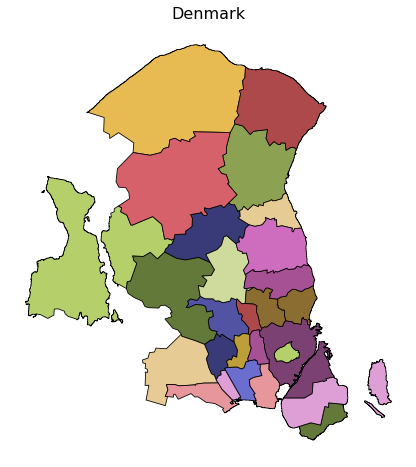

In [5]:
# Filter on the areas we want displayed
hovedstaden = gdf[(gdf.ID_1==1) & (gdf.NAME_2 != 'Bornholm') & (gdf.NAME_2 != 'Christiansø') & (gdf.NAME_2 != 'Halsnæs')]

# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
hovedstaden.plot(column='ID_2', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=False);
ax.axis('off');
ax.set_title('Denmark', fontsize=16);

In order to change that, an additional shapefile dataset has to be downloaded and the two geodatasets merged together.
**Open Data DK** has a shapefile dataset available that contains the differente areas (bydele) of Copenhagen. The data was downloaded from their [webpage](https://www.opendata.dk/city-of-copenhagen/bydele#resource-bydele.csv). The analysis will be focused on the Copenhagen area, as it was clear from the **Milestone 1** notebook, that most of the restaurants are located in that area. 

Since Frederiksberg is enclosed by Copenhagen, it will be included in the analysis, by using the data from the previously gathered shapefiles and merging it with the data about the Copenhagen areas. Additionally, the information about the area of Frederiksberg was gathered from [Wikipedia](https://en.wikipedia.org/wiki/Frederiksberg) and added to the geopandas dataframe and the results then plotted.

In [6]:
# Gather the shapefiles and display - There are only 10 areas
gdf_cph = gpd.read_file('bydel/bydel.shp')

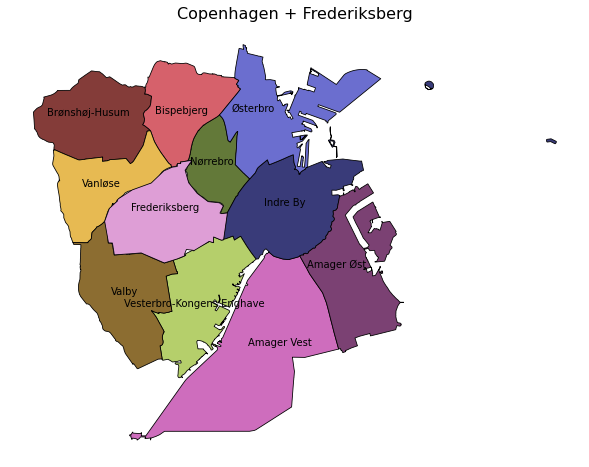

In [7]:
# Add information about Frederiksberg to the dataset
# It will have an ID of 11 and bydel_nr 11
# Navn is Frederiksberg
# Area m2 8.7 km2 according to Wikipedia https://en.wikipedia.org/wiki/Frederiksberg
# Get geometry from gdf previously created
frb = [11, 11.0, 'Frederiksberg', 8700000, hovedstaden[hovedstaden.NAME_2 == 'Frederiksberg'].geometry.values[0]]
frb_pd = pd.DataFrame([frb], columns=['id', 'bydel_nr', 'navn', 'areal_m2', 'geometry']) 

# Append to the cph dataset
gdf_cph = gdf_cph.append(frb_pd)

# Plot the shapefiles and add labels.
# Source: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
gdf_cph['coords'] = gdf_cph['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_cph['coords'] = [coords[0] for coords in gdf_cph['coords']]

# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph.plot(column='id', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=False);
ax.axis('off');
ax.set_title('Copenhagen + Frederiksberg', fontsize=16);
for idx, row in gdf_cph.iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

The different areas of Copenhagen can now be seen on the shapefile, with Frederiksberg included. These areas will be the main focus of the analysis. The geopandas dataframe also includes information about the area (m^2) of each neighbourhood as well as the population of each one. These will come in handy later on.

<a id='enrich'></a>
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# 2. Data exploration and enrichment 🧐
Some further data exploration and enrichment will be performed, on top of what was already done in the **Milestone 1** notebook. 

As preperation for the business questions to be answered later on, and as further data exploration the following will be investigated:

* [2.1 Location data](#location)
* [2.2 Review text clean up](#clean_text)
* [2.3 Find all Pizza restaurants](#pizza)
* [2.4 Review Sentiment](#sentiment) 
* [2.5 Opening date/Closing date](#openclose)
* [2.6 Estimators for popularity](#popularity)

<a id='location'></a>
## 2.1 Location data📍
>**Mission**: Use generated shapefile to find out which area of Copenhagen each restaurant is located in. Filter dataset on those restaurants.

Before it is possible to use the latitude and longitude data, it needs to be converted to a float value.
The number of reviews that each restaurant has is also converted into an integer at the same time, just for convenience.

In [8]:
# Convert lat, lon from string to float in the dataframe
restaurants.lat = restaurants.lat.apply(lambda x: float(x) if x is not None else None)
restaurants.lon = restaurants.lon.apply(lambda x: float(x) if x is not None else None)

# At the same time convert the nrReviews into int
restaurants.nrReviews = restaurants.nrReviews.apply(lambda x: int(x.replace(',', '')))

Then a function can be defined that takes as an input lat and lon data, along with a geopandas dataframe. It checks if the lat and lon are provided. If both are None then based on the cell above, it is clear that there is no location data provided. If neither are None then the lat and lon data is used to create a Shapely type Point from the data. That point is then compared with all the polygons in the shapefile, and the name of the area that contains the point is returned.

In [9]:
# Inspiration from: https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon

def which_area(lon, lat, gpd):
    
    # If we have no location information -> no need to check all areas -> return None
    if lat is None or np.isnan(lat):
        return None

    # create a shapely Point from the lat and lon coordinates
    point = Point(lon, lat) # create point
    
    # Go through each area in the pdf shapefile and check if within area
    for idx, row in gpd.iterrows():
        polygon = row.geometry
        
        # check if ploygon contains plot, point is in polygon or on border
        if polygon.contains(point) or point.within(polygon) or polygon.touches(point):
            return row.navn
    
    return None

Then the function can be run on the whole **restaurants** dataframe and a new column called **area** generated

In [10]:
# Find the area for each restaurant
areas = []
for idx, row in restaurants.iterrows():
    area = which_area(row.lon, row.lat, gdf_cph)
    areas.append(area)

restaurants['area'] = areas
restaurants.head(2)

storeName                                    storeAddress  \
0  Maple Casual Dining       Vesterbrogade 24, Copenhagen 1620 Denmark   
1        Keyser Social  Frederiksborggade 20d, Copenhagen 1360 Denmark   

   avgRating  nrReviews  priceCategory  \
0        5.0        237            2.5   
1        5.0        125            4.0   

                                      CousineType  \
0  [International, European, Vegetarian Friendly]   
1              [Asian, Thai, Vegetarian Friendly]   

                                           all_ranks  \
0  [#1 of 95 International in Copenhagen, #1 of 1...   
1            [#2 of 1,971 Restaurants in Copenhagen]   

                                   all_ratings        lat        lon  \
0  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.672958  12.558138   
1  [(Food, 5.0), (Service, 5.0), (Value, 5.0)]  55.683950  12.571327   

                                            location  \
0  Maple Casual Dining, Vesterbrogade, Kødbyen, V...   
1  Keyser Social, Frederiksborggade, Frederikssta...   

                        area  
0  Vesterbro-Kongens Enghave  
1                   Indre By

We now have information in the **restaurants** dataframe about which area the restaurant is located in. In total there are around 20% of the restaurants in the dataset that are located outside of the Copenhagen capital area.

In [11]:
print("Percentage of restaurants in dataset that are not located in the 11 areas of the Capital Copenhagen area: ")
print(round((len(restaurants[restaurants['area'].isnull()]) / len(restaurants) * 100),2), "%")

Percentage of restaurants in dataset that are not located in the 11 areas of the Capital Copenhagen area: 
19.48 %


Lets create a new dataset that is filtered only on those restaurants that are within the Copenhagen area. The dataset contains information about 1889 restaurants.

In [12]:
restaurants_cph = restaurants[~restaurants['area'].isnull()]
len(restaurants_cph)

1889

To get a sense of the distribution of restaurants, each restaurant was plotted (in white) on top of the different areas of the capital area. As previously, each area is plotted in a different color according to its ID.

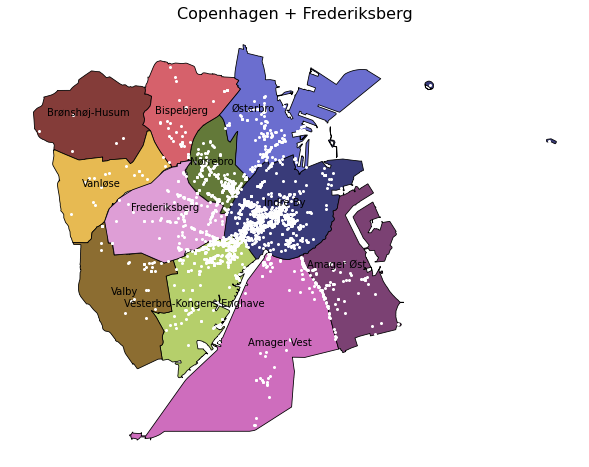

In [13]:
# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph.plot(column='id', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=False);
ax.axis('off');
ax.set_title('Copenhagen + Frederiksberg', fontsize=16);

for idx, row in restaurants_cph.iterrows():
    ax.plot(row['lon'], row['lat'], markersize=2, marker='o', color='white')

for idx, row in gdf_cph.iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

Now it can clearly be seen that the majority of the restaurants are located in Indre By and the neighbouring areas, such as Vesterbro, Nørrebro and Østerbro.

>**Conclusion**: We now have information about which area each restaurant is located in and have filtered the dataset to only include restaurants in the Copenhagen capital area.

<a id='clean_text'></a>
## 2.2 Review text clean up 🧼

>**Mission**: Preprocess the review text, and generate term frequencies for each review and combine them for each restaurant.

Before raw text can be used for analysis, it is necessary to clean the text up first. The first step is to read in all the reviews, and do some necessary type conversion. Since additional reviews were added after the **Milestone 1** notebook, there reviews will be read directly from the source, and the ratingDate converted to a datetime object.

In [14]:
# Since the reviews kept being added on to, read directly from data
reviews = pd.read_csv('Data/all_reviews.csv')

# Convert the rating date from string to datetime
reviews['ratingDate'] = reviews['ratingDate'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))

In [15]:
len(reviews)

109749

In total there are 109.749 reviews, but since there appear to be some duplicates from the data extraction, those will be dropped using pandas drop duplicates.

In [16]:
reviews = reviews.drop_duplicates()

In [17]:
len(reviews)

89200

After dropping duplicates there are 89.200 reviews in the dataset

Then the **nltk** package will be used for preprocessing the data. A function was created that does the following text clean up:
* Remove some html leftovers in the text (\n\n which is the newline character)
* Tokenize the words, splitting each review up into a list of words
* All punctuation is removed and all words cast to lowercase
* Stop words are removed
* Words are lemmatized

In [18]:
# Create a lemmatization object to use and stopwords
stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

# Function from week 2 modified
def text_processing(text):
    
    # The text input is a string containing a textual review
    # The function will output a list of the words in the review (tokenize), after removing punctuation, making 
    # everything lowercase, skipping all punctuation and common stopwords 
    
    # First the \n\n is replaced by space, but \n is the newline character
    text = text.replace('\n\n', ' ')
    
    # Then tokenize the words, splitting the string up into a list of all the words
    tokens = nltk.word_tokenize(text)
    
    # remove punctuation and make lower case
    words = [w.lower() for w in tokens if w not in string.punctuation]
    
    # lemmetize and remove stopwords
    #words = " ".join([wnl.lemmatize(w) for w in words if w not in stopwords])
    words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    
    return words

The functionality of the function is then tested to show that it is working properly before proceeding. It's important to note that some of the common stopwords include negation words, such as 'not' so the whole context of the review can change when the text is processed in this way.

In [19]:
text_processing("The food was not very good. Do not! recommend.")

['food', 'good', 'recommend']

After applying the function to the whole dataframe and generating a new column, the reviews dataframe is as follows.
For the text clean up, both the reviewHeader and reviewText were used as a whole, to include the total review text.

In [20]:
reviews['text_clean'] = reviews.apply(lambda x: text_processing(x.reviewHeader + " " + x.reviewText), axis=1)

In [21]:
reviews.head(3)

storeName reviewerUsername ratingDate  \
0  Maple Casual Dining         918emmaf 2020-12-05   
1  Maple Casual Dining      hildurj2016 2020-11-19   
2  Maple Casual Dining           Judy B 2020-10-27   

                 reviewHeader  \
0                   Exquisite   
1      Perfect wedding dinner   
2  Beautifully Presented Food   

                                          reviewText  rating  \
0  We visited Maple in Friday night and had a won...       5   
1  Excellent food, drinks and service!! Me and my...       5   
2  I visited this restaurant on my first ever vis...       5   

                                          text_clean  
0  [exquisite, visited, maple, friday, night, won...  
1  [perfect, wedding, dinner, excellent, food, dr...  
2  [beautifully, presented, food, visited, restau...

The dataset now includes information about the clean text of each review.

### Create Term Frequencies for each review

Using the cleaned text, a term frequency distribution was generated for each review, using the FreqDist function from **nltk**. It generates a special type of dictionary, where each word is the key and the frequency is the corresponding value.

In [22]:
# Generate a frequency distribution (term frequency) of each review
reviews['tf'] = reviews.apply(lambda x: nltk.FreqDist(x.text_clean), axis=1)
reviews.head(3)

storeName reviewerUsername ratingDate  \
0  Maple Casual Dining         918emmaf 2020-12-05   
1  Maple Casual Dining      hildurj2016 2020-11-19   
2  Maple Casual Dining           Judy B 2020-10-27   

                 reviewHeader  \
0                   Exquisite   
1      Perfect wedding dinner   
2  Beautifully Presented Food   

                                          reviewText  rating  \
0  We visited Maple in Friday night and had a won...       5   
1  Excellent food, drinks and service!! Me and my...       5   
2  I visited this restaurant on my first ever vis...       5   

                                          text_clean  \
0  [exquisite, visited, maple, friday, night, won...   
1  [perfect, wedding, dinner, excellent, food, dr...   
2  [beautifully, presented, food, visited, restau...   

                                                  tf  
0  {'exquisite': 2, 'visited': 1, 'maple': 1, 'fr...  
1  {'perfect': 2, 'wedding': 2, 'dinner': 2, 'exc...  
2  {'beautifully': 1, 'presented': 1, 'food': 1, ...

### Create combined Term Frequency for each restaurant
Now it is possible to sum together the term frequencies of the reviews, into a single term frequency distribution for each restaurant. This is done by groupping the reviews by the restaurant name, and summing the term frequencies together.

In [23]:
# Generate the groupped and summed term frequencies for each store
restaurant_tfs = reviews.groupby('storeName')['tf'].agg('sum')

# Merge the term frequency into the restaurants dataframe
restaurants_cph = pd.merge(restaurants_cph, restaurant_tfs, left_on='storeName', right_on='storeName', how='left')

# Check how it looks
restaurants_cph.head(3)

storeName                                    storeAddress  \
0       Maple Casual Dining       Vesterbrogade 24, Copenhagen 1620 Denmark   
1             Keyser Social  Frederiksborggade 20d, Copenhagen 1360 Denmark   
2  Restaurant Krebsegaarden       Studiestraede 17, Copenhagen 1455 Denmark   

   avgRating  nrReviews  priceCategory  \
0        5.0        237            2.5   
1        5.0        125            4.0   
2        5.0       1403            4.0   

                                      CousineType  \
0  [International, European, Vegetarian Friendly]   
1              [Asian, Thai, Vegetarian Friendly]   
2                [European, Scandinavian, Danish]   

                                           all_ranks  \
0  [#1 of 95 International in Copenhagen, #1 of 1...   
1            [#2 of 1,971 Restaurants in Copenhagen]   
2  [#2 of 840 European in Copenhagen, #3 of 1,971...   

                                         all_ratings        lat        lon  \
0        [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.672958  12.558138   
1        [(Food, 5.0), (Service, 5.0), (Value, 5.0)]  55.683950  12.571327   
2  [(Food, 5.0), (Service, 5.0), (Value, 4.5), (A...  55.678704  12.569991   

                                            location  \
0  Maple Casual Dining, Vesterbrogade, Kødbyen, V...   
1  Keyser Social, Frederiksborggade, Frederikssta...   
2  17, Studiestræde, Vesterbro, København, Københ...   

                        area  \
0  Vesterbro-Kongens Enghave   
1                   Indre By   
2                   Indre By   

                                                  tf  
0  {'exquisite': 2, 'visited': 6, 'maple': 20, 'f...  
1  {'amazing': 9, 'experience': 9, '13-course': 3...  
2  {'birthday': 36, 'visit': 95, 'well': 175, 'lo...

### Create a normalized Term Frequency for each restaurant
Since each restaurant has a different number of reviews, and the reviews are of different lengths, a new column called **tf_norm** is generated, where each tf is normalized based on the number of words in the reviews of that restaurant. That way it is easier to see the relative frequency of each word in the reviews.

In [24]:
# Generate a deep copy of the frequency distribution we currently have for each restaurant
restaurants_cph['tf_norm'] = restaurants_cph.apply(lambda x: copy.deepcopy(x.tf), axis=1)

# For each restaurant
for idx, r in restaurants_cph.iterrows():
    
    if pd.isna(r.tf):
        pass
    else:
        # Calculate the number of words in the tf
        total = sum(r.tf.values())

        # for each word in the tf_norm
        for word in r.tf:
            r.tf_norm[word] = r.tf[word] / total
        
# Check that it works
restaurants_cph.head(3)

storeName                                    storeAddress  \
0       Maple Casual Dining       Vesterbrogade 24, Copenhagen 1620 Denmark   
1             Keyser Social  Frederiksborggade 20d, Copenhagen 1360 Denmark   
2  Restaurant Krebsegaarden       Studiestraede 17, Copenhagen 1455 Denmark   

   avgRating  nrReviews  priceCategory  \
0        5.0        237            2.5   
1        5.0        125            4.0   
2        5.0       1403            4.0   

                                      CousineType  \
0  [International, European, Vegetarian Friendly]   
1              [Asian, Thai, Vegetarian Friendly]   
2                [European, Scandinavian, Danish]   

                                           all_ranks  \
0  [#1 of 95 International in Copenhagen, #1 of 1...   
1            [#2 of 1,971 Restaurants in Copenhagen]   
2  [#2 of 840 European in Copenhagen, #3 of 1,971...   

                                         all_ratings        lat        lon  \
0        [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.672958  12.558138   
1        [(Food, 5.0), (Service, 5.0), (Value, 5.0)]  55.683950  12.571327   
2  [(Food, 5.0), (Service, 5.0), (Value, 4.5), (A...  55.678704  12.569991   

                                            location  \
0  Maple Casual Dining, Vesterbrogade, Kødbyen, V...   
1  Keyser Social, Frederiksborggade, Frederikssta...   
2  17, Studiestræde, Vesterbro, København, Københ...   

                        area  \
0  Vesterbro-Kongens Enghave   
1                   Indre By   
2                   Indre By   

                                                  tf  \
0  {'exquisite': 2, 'visited': 6, 'maple': 20, 'f...   
1  {'amazing': 9, 'experience': 9, '13-course': 3...   
2  {'birthday': 36, 'visit': 95, 'well': 175, 'lo...   

                                             tf_norm  
0  {'exquisite': 0.0006666666666666666, 'visited'...  
1  {'amazing': 0.016423357664233577, 'experience'...  
2  {'birthday': 0.0011352527514111822, 'visit': 0...

>**Conclusion:** Now the term frequencies of each review and combined term frequencies for each restaurant are ready to be used.

<a id='pizza'></a>
## 2.3 Find all Pizza restaurants 🍕
>**Mission**: Find all the restaurants that sell Pizza, and filter the dataset on those.


In order to filter the dataset to only include the restaurants that offer Pizza, three things will be used:
* The CousineType of each restaurant (if it contains Pizza)
* The restaurants name (if it contains Pizza, Pizzeria, or something similar)
* If any review mentioned Pizza (using tf of each restaurant)


The first step is to find all the restaurants that have a review that includes the word 'pizza' and mark those as having a review that includes pizza.

In [25]:
# Find all restaurants that have the word 'pizza' and mark those with 1
restaurants_cph['review_pizza'] = restaurants_cph.apply(lambda x: 0 if pd.isna(x.tf) or x.tf['pizza']==0 else 1, axis=1)

The second step is to check if the Cousine Type of the restaurant is 'Pizza' or if the name of the restaurant has the substring 'pizz'. After combining those and using as a filter, the results will be a dataframe filtered to only include the restaurants that sell pizzas.

In [26]:
# Generate a list marking if a restaurant has pizza or not
has_pizza = []

# For each restaurant, if they have Pizza as cousine type, pizz in the name or have a review with pizza - append 1
for idx, row in restaurants_cph.iterrows():
    if 'Pizza' in row.CousineType or 'pizz' in row.storeName.lower() or row.review_pizza==1:
        has_pizza.append(1)
    else:
        has_pizza.append(0)

# add filter column to dataframe
restaurants_cph['has_pizza'] = has_pizza

# Create new dataframe using the filter column and remove uncessary columns
pizza = restaurants_cph[restaurants_cph.has_pizza == 1].reset_index(drop=True)
del pizza['has_pizza']
del pizza['review_pizza']

In [27]:
pizza.head(3)

storeName                                     storeAddress  \
0  The Olive Kitchen & Bar           Noerregade 22, Copenhagen 1165 Denmark   
1                      Ark  Noerre Farimagsgade 63, Copenhagen 1364 Denmark   
2    Madbaren Marmorkirken    Store Kongensgade 77, Copenhagen 1264 Denmark   

   avgRating  nrReviews  priceCategory  \
0        5.0       2413            2.5   
1        5.0        277            2.5   
2        5.0        249            1.0   

                                      CousineType  \
0  [International, European, Gluten Free Options]   
1               [European, Contemporary, Healthy]   
2          [Pizza, European, Vegetarian Friendly]   

                                           all_ranks  \
0            [#4 of 1,971 Restaurants in Copenhagen]   
1  [#5 of 840 European in Copenhagen, #5 of 1,971...   
2            [#6 of 1,971 Restaurants in Copenhagen]   

                                   all_ratings        lat        lon  \
0  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.681248  12.571325   
1  [(Food, 4.5), (Service, 5.0), (Value, 4.5)]  55.685251  12.568363   
2  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.685248  12.588337   

                                            location      area  \
0  22, Nørregade, Vesterbro, København, København...  Indre By   
1  Ark, Nørre Farimagsgade, Frederiksstaden, Købe...  Indre By   
2  Madbaren Marmorkirken, Store Kongensgade, Fred...  Indre By   

                                                  tf  \
0  {'fun': 17, 'night': 224, 'great': 825, 'frien...   
1  {'great': 113, 'spot': 3, 'vegan': 183, 'enjoy...   
2  {'tasty': 22, 'food': 54, 'place': 65, 'offer'...   

                                             tf_norm  
0  {'fun': 0.0003945414036390642, 'night': 0.0051...  
1  {'great': 0.0199929228591649, 'spot': 0.000530...  
2  {'tasty': 0.008127077946065755, 'food': 0.0199...

In [28]:
len(pizza)

305

>**Conclusion**: So now the dataset has been filtered down to 305 restaurants, that all seem to offer pizzas, even if they don't specifically advertise themselves as pizzerias.

<a id='sentiment'></a>
## 2.4 Review Sentiment 👍
>**Mission**: Analyse the sentiment of each review and generate the average review sentiment of each restaurant.

The sentiment of the review text, should in theory be very telling of how the customers' experience at the restaurant was.
In order to compute the sentiment of a review, the **NLTK** package was used. It contains the **SentimentIntensityAnalyzer** which computes the positivity/neutrality/negativity of text as explained in the [documentation](https://www.nltk.org/api/nltk.sentiment.html).

*It's important to note the that raw review is used as input in the function*. The reason being that if any cleanup had been performed before, it could have a significant impact on the results.
As an example:
* The food was not very good. Do not recommend.

If this sentence would be cleaned up and common stop words removed, then the *not* would be removed and the sentance became:
* food good recommend

The Sentiment Intensity Analyzer has ways of handling negation such as "not good" and therefore it is important to keep the original context of the review text when evaluating the sentiment.

It's also important to include the text from **reviewHeader** in the sentiment analysis, as that can be considered to be an important part of the review.

In order to make the analysis quicker, the reviews dataset is filtered to only contain the reviews relating to the set of restaurants offering pizza, as were extracted in the previous section [2.3 Find all Pizza restaurants](#pizza).
Then the sentiment analysis was performed and a new column generated in the reviews dataset

In [29]:
# First the reviews dataframe is filtered to include only the pizza places
reviews = reviews[reviews.storeName.apply(lambda x: x in set(pizza.storeName))]

# generate the Sentiment Intensity Analyzer object
sia = SentimentIntensityAnalyzer()

# Create a new column in the reviews dataset, that uses
reviews['sentiment'] = (reviews['reviewHeader'] + " " + reviews['reviewText']).replace('\n\n', ' ').apply(lambda x: sia.polarity_scores(x)['compound']);


In [30]:
reviews.sample(5)

storeName reviewerUsername ratingDate  \
61430        Greasy Spoon       bluehammer 2014-08-19   
56184   Filini Restaurant       BenediktA1 2017-12-13   
78526  La Vecchia Signora      skovmeister 2016-07-07   
15243     Il Grappolo Blu      Torben_Lyst 2015-03-01   
48777              Mother          98rezas 2020-02-12   

                                    reviewHeader  \
61430                      Great spot for Lunch.   
56184  Good atmosphere and great wine collection   
78526   Best italian everyday restaurant in town   
15243                        Exceptional Service   
48777                            Romantic dinner   

                                              reviewText  rating  \
61430  Cool name, cool decor, nice staff and good tun...       4   
56184  Very friendly staff, tasty food and great sele...       5   
78526  Please do yourself a big favor and go visit th...       5   
15243                                               Int        5   
48777  Awesome pizza and house wine\nReally surprised...       5   

                                              text_clean  \
61430  [great, spot, lunch, cool, name, cool, decor, ...   
56184  [good, atmosphere, great, wine, collection, fr...   
78526  [best, italian, everyday, restaurant, town, pl...   
15243                        [exceptional, service, int]   
48777  [romantic, dinner, awesome, pizza, house, wine...   

                                                      tf  sentiment  
61430  {'great': 1, 'spot': 1, 'lunch': 1, 'cool': 2,...     0.9850  
56184  {'good': 1, 'atmosphere': 1, 'great': 3, 'wine...     0.9701  
78526  {'best': 1, 'italian': 2, 'everyday': 1, 'rest...     0.9253  
15243         {'exceptional': 1, 'service': 1, 'int': 1}     0.0000  
48777  {'romantic': 1, 'dinner': 1, 'awesome': 1, 'pi...     0.9577

In order to check out the generated sentiments, all the sentiment scores where plotted on a histogram by the review rating.

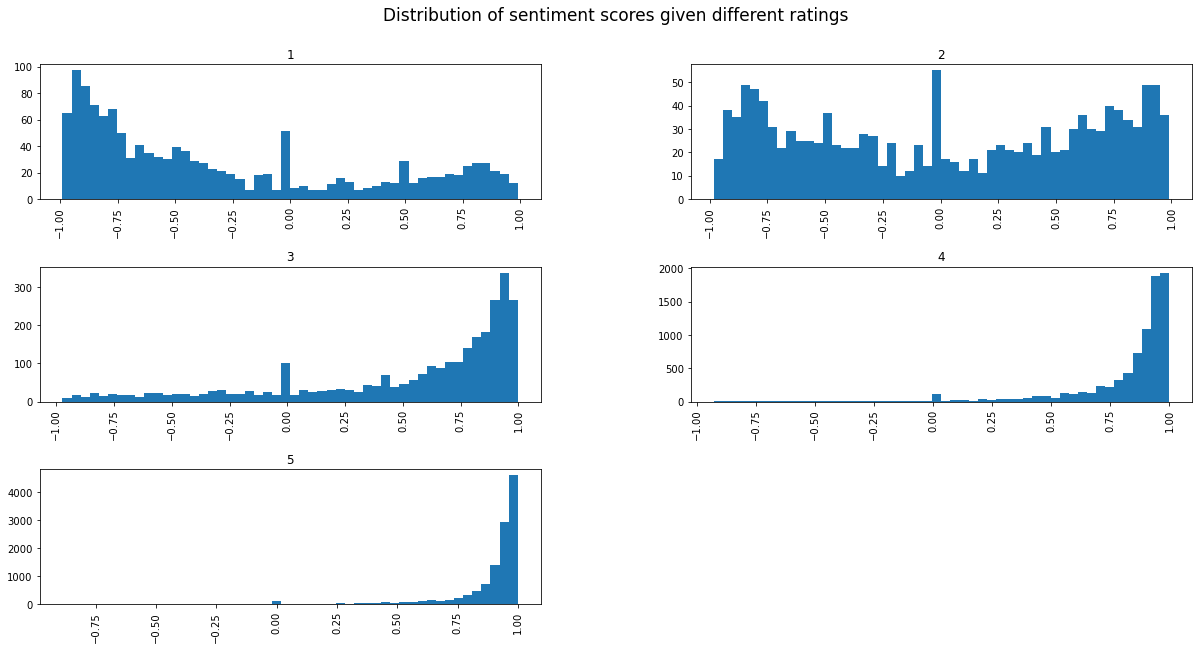

In [31]:
# Plot the distributions of sentiment given the review rating
axes = reviews.hist(column='sentiment', by='rating', bins=50, figsize=(20,10))
plt.suptitle("Distribution of sentiment scores given different ratings", size=17);

From the above histograms it can clearly be seen that reviews of 4 and 5 almost exclusively have a positive sentiment. The majority of reviews with a rating 3 also have a positive sentiment, although it is slighlty lower than for the higher ratings. Reviews of rating 2 have a pretty balanced sentiment scores, while the reviews with rating 1 have a majority of reviews with negative sentiment.

In some cases can the data discrepancies be explained by the reviews including positive words, that are not applied to the restaurant in question such as in the review below "*There are many other wonderful Italian restaurants in Copenhagen as we have discovered. Walk pass La Rocca and find a friendlier and more welcoming place*"

In [32]:
reviews[(reviews.sentiment>0.98) & (reviews.rating==1) & (reviews.reviewerUsername=='Gerrygym')].reviewText.values[0]

'I was in Copenhagen for business and stayed at Kong Arthur. They recommended I take my business associate to La Rocca since I wanted to have Italian for a change from Nordic cuisine. In an attempt to see if a table was available (without a booking) I was greeted by an abrupt and extremely rude Maître D’. I completely understand that without a reservation,it is unlikely I would get seated but his incredibly rude mannerism towards me and my associate convinced me I would never go back and having to share my experience so others would know that even popular restaurants started with the humblest of beginnings. A steady stream of new customers are the life-blood of any restaurant regardless of how successful they become. Having a business of my own, I only know too well the power of reputation and referrals. I would urge you to consider an alternate if you are considering La Rocca. Humility and customer focus is key to long term success. Lesson: Never say “No! We have nothing - not even la

### Generate average review sentiment for each restaurant
Finally the review sentiments were aggregated, and the average review sentiment of each restaurant generated. 

In [33]:
avg_sentiments = reviews.groupby('storeName')['sentiment'].agg('mean')

# Merge the sentiment info with the restaurants_cph
pizza = pd.merge(pizza, avg_sentiments, left_on='storeName', right_on='storeName', how='left')

In [34]:
pizza.head(3)

storeName                                     storeAddress  \
0  The Olive Kitchen & Bar           Noerregade 22, Copenhagen 1165 Denmark   
1                      Ark  Noerre Farimagsgade 63, Copenhagen 1364 Denmark   
2    Madbaren Marmorkirken    Store Kongensgade 77, Copenhagen 1264 Denmark   

   avgRating  nrReviews  priceCategory  \
0        5.0       2413            2.5   
1        5.0        277            2.5   
2        5.0        249            1.0   

                                      CousineType  \
0  [International, European, Gluten Free Options]   
1               [European, Contemporary, Healthy]   
2          [Pizza, European, Vegetarian Friendly]   

                                           all_ranks  \
0            [#4 of 1,971 Restaurants in Copenhagen]   
1  [#5 of 840 European in Copenhagen, #5 of 1,971...   
2            [#6 of 1,971 Restaurants in Copenhagen]   

                                   all_ratings        lat        lon  \
0  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.681248  12.571325   
1  [(Food, 4.5), (Service, 5.0), (Value, 4.5)]  55.685251  12.568363   
2  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.685248  12.588337   

                                            location      area  \
0  22, Nørregade, Vesterbro, København, København...  Indre By   
1  Ark, Nørre Farimagsgade, Frederiksstaden, Købe...  Indre By   
2  Madbaren Marmorkirken, Store Kongensgade, Fred...  Indre By   

                                                  tf  \
0  {'fun': 17, 'night': 224, 'great': 825, 'frien...   
1  {'great': 113, 'spot': 3, 'vegan': 183, 'enjoy...   
2  {'tasty': 22, 'food': 54, 'place': 65, 'offer'...   

                                             tf_norm  sentiment  
0  {'fun': 0.0003945414036390642, 'night': 0.0051...   0.877699  
1  {'great': 0.0199929228591649, 'spot': 0.000530...   0.860398  
2  {'tasty': 0.008127077946065755, 'food': 0.0199...   0.904946

>**Conclusion:** Now the average sentiment score of each restaurant is available in the dataset.

<a id='openclose'></a>
## 2.5 Opening date/Closing date 🎊

>**Mission:** Use review dates to estimate opening date/closing date of each restaurant, using the oldest and newest review dates.

The dataset does not include information about the opening date/closing date of each restaurant, but it might be very valuable information for further analysis.

In order to estimate these dates, the date of reviews will be used.
The opening date will be estimated based on the date of the oldest review, while the closing date will be estimated based on the date of the most recent review. 
If the most recent review date is around mid December 2020 or after that, then the restaurant can be assumed to still be in business.

Due to COVID, there were many restaurants that had to close down, as soon as the Danish government imposed a lockdown in Denmark. That forced all non-essential businesses to close down temporarily. Some restaurants were able to still operate, while only allowing take-away. 


In [35]:
# Get the minimum rating date for each restaurant
start_dates = reviews.groupby('storeName')['ratingDate'].agg(np.min)

# Merge the minimum date info with the restaurants_cph
pizza = pd.merge(pizza, start_dates, left_on='storeName', right_on='storeName', how='left')
pizza = pizza.rename(columns={"ratingDate": "min_ratingDate"})

# Do the same to get the newest rating date
lates_dates = reviews.groupby('storeName')['ratingDate'].agg(np.max)
pizza = pd.merge(pizza, lates_dates, left_on='storeName', right_on='storeName', how='left')
pizza = pizza.rename(columns={"ratingDate": "max_ratingDate"})

pizza.head(3)

storeName                                     storeAddress  \
0  The Olive Kitchen & Bar           Noerregade 22, Copenhagen 1165 Denmark   
1                      Ark  Noerre Farimagsgade 63, Copenhagen 1364 Denmark   
2    Madbaren Marmorkirken    Store Kongensgade 77, Copenhagen 1264 Denmark   

   avgRating  nrReviews  priceCategory  \
0        5.0       2413            2.5   
1        5.0        277            2.5   
2        5.0        249            1.0   

                                      CousineType  \
0  [International, European, Gluten Free Options]   
1               [European, Contemporary, Healthy]   
2          [Pizza, European, Vegetarian Friendly]   

                                           all_ranks  \
0            [#4 of 1,971 Restaurants in Copenhagen]   
1  [#5 of 840 European in Copenhagen, #5 of 1,971...   
2            [#6 of 1,971 Restaurants in Copenhagen]   

                                   all_ratings        lat        lon  \
0  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.681248  12.571325   
1  [(Food, 4.5), (Service, 5.0), (Value, 4.5)]  55.685251  12.568363   
2  [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.685248  12.588337   

                                            location      area  \
0  22, Nørregade, Vesterbro, København, København...  Indre By   
1  Ark, Nørre Farimagsgade, Frederiksstaden, Købe...  Indre By   
2  Madbaren Marmorkirken, Store Kongensgade, Fred...  Indre By   

                                                  tf  \
0  {'fun': 17, 'night': 224, 'great': 825, 'frien...   
1  {'great': 113, 'spot': 3, 'vegan': 183, 'enjoy...   
2  {'tasty': 22, 'food': 54, 'place': 65, 'offer'...   

                                             tf_norm  sentiment  \
0  {'fun': 0.0003945414036390642, 'night': 0.0051...   0.877699   
1  {'great': 0.0199929228591649, 'spot': 0.000530...   0.860398   
2  {'tasty': 0.008127077946065755, 'food': 0.0199...   0.904946   

  min_ratingDate max_ratingDate  
0     2016-01-30     2020-11-28  
1     2018-06-04     2020-12-28  
2     2017-02-28     2021-03-27

### Edge cases when the restaurants have no reviews
Since not all the restaurants have reviews, it will not be possible to estimate the opening/closing dates based on the dates of reviews. Since these columns will be used later on, the simplest way is to drop these rows.
Below is an example of 3 restaurants containing no ratings, no reviews and therefore no min_ratingDate or max_ratingDate

In [36]:
pizza[['storeName', 'avgRating', 'nrReviews', 'area', 'min_ratingDate', 'max_ratingDate']].tail(3)

storeName  avgRating  nrReviews                       area  \
302       Bereket Pizzeria        NaN          0  Vesterbro-Kongens Enghave   
303      Bentzons Pizzaria        NaN          0              Frederiksberg   
304  Esperia Pizzabar 2000        NaN          0                      Valby   

    min_ratingDate max_ratingDate  
302            NaT            NaT  
303            NaT            NaT  
304            NaT            NaT

In total there are 16 pizza restaurants that contain no English reviews. 

In [37]:
len(pizza[pizza['min_ratingDate'].isnull()])

16

Since there is very little information about these restaurants, and no reviews, it might be most benefitial to simply drop them from the analysis. 
Another way would have been to hard code their opening/closing dates as the beginning and ending of the review period. Indicating that the restaurants would have been operational from 2007 until 2021. However it seems highly unlikely that the resturants would be open for such a long time, without receiving a single English review. Therefore it seems to be better representitive to simply remove those restaurants, that have no ratings.

In [38]:
pizza = pizza[~pizza['min_ratingDate'].isnull()]
len(pizza)

289

So the final pizza dataset has 289 restaurants.
>**Conclusion:** The opening/closing date of each restaurant has been estimated and restaurants with no English reviews dropped from the analysis.

![img](https://media0.giphy.com/media/S4HkoX3Qpqt5yGQqGs/200.gif)

<a id='popularity'></a>
## 2.6 Estimators for popularity 🌟
>**Mission**: Create a simple estimator of popularity that can be used in further analysis later on.

In order to create simple estimators of popularity, the number of reviews, per day open, was generated for each restaurant. Since the English reviews are the only reviews used in this analysis, the main estimator will be:

* Number of English reviews per day for opening period

However for comparison another popularity estimator will be generated from the total number of reviews:

* Number of reviews per day for opening period

In order to account for the last day of the opening period, a +1 was added to the period. Otherwise the restaurants that only have a single review, would be counted as having been open zero days.

The first step is to calculate the number of reviews per day given all the languages of the reviews.

In [39]:
# Calculate average ratings per day - indicator for popularity
pizza['nrReviews_per_day'] = pizza.nrReviews / ((pizza.max_ratingDate - pizza.min_ratingDate).dt.days+1)

Then the same metric is created using the number of English reviews, and the popularity calculated from that.

In [40]:
# Count the number of reviews 
counts = reviews.groupby('storeName')['reviewText'].agg('count')

# Merge the counts info with the restaurants_cph
pizza = pd.merge(pizza, counts, left_on='storeName', right_on='storeName', how='left')
pizza = pizza.rename(columns={"reviewText": "nrReviews_EN"})

In [41]:
# Calculate average number of reviews per day in ENGLISH - indicator for popularity
pizza['nrReviews_per_day_EN'] = pizza.nrReviews_EN / ((pizza.max_ratingDate - pizza.min_ratingDate).dt.days+1)

Now there are some new columns in the dataset that contain the popularity information. Lets visualize those.

In [42]:
pizza.sample(3)

storeName  \
19                     Da Salvo   
208            Quattro Stagioni   
3    Pizzeria Mamemi & Wine Bar   

                                          storeAddress  avgRating  nrReviews  \
19   Gammel Kongevej 41 Frederiksberg, Copenhagen 1...        4.5        305   
208                    Solvgade 90, Copenhagen Denmark        4.5          8   
3              Mysundegade 28, Copenhagen 1668 Denmark        5.0       1126   

     priceCategory                      CousineType  \
19             2.5  [Italian, Pizza, Mediterranean]   
208            NaN                               []   
3              1.0  [Italian, Pizza, Mediterranean]   

                                             all_ranks  \
19           [#163 of 1,971 Restaurants in Copenhagen]   
208                                                 []   
3    [#1 of 238 Italian in Copenhagen, #11 of 1,971...   

                                           all_ratings        lat        lon  \
19   [(Food, 4.5), (Service, 4.5), (Value, 4.5), (A...  55.673556  12.554736   
208                                                 []  55.689996  12.573398   
3          [(Food, 5.0), (Service, 5.0), (Value, 4.5)]  55.667879  12.547963   

                                              location  \
19   Gammel Kongevej, Frederiksberg, Frederiksberg ...   
208  Le Quattro Stagioni Uno, Sølvgade, Frederiksst...   
3    28, Mysundegade, Sorte Hest, Vesterbro, Københ...   

                          area  \
19               Frederiksberg   
208                   Indre By   
3    Vesterbro-Kongens Enghave   

                                                    tf  \
19   {'terrible': 4, 'take': 4, 'away': 4, 'pizza':...   
208  {'great': 2, 'take': 1, 'away': 1, 'pizza': 10...   
3    {'amazing': 112, 'take': 16, 'away': 7, 'food'...   

                                               tf_norm  sentiment  \
19   {'terrible': 0.0014760147601476014, 'take': 0....   0.683906   
208  {'great': 0.01904761904761905, 'take': 0.00952...   0.914733   
3    {'amazing': 0.00943952802359882, 'take': 0.001...   0.851159   

    min_ratingDate max_ratingDate  nrReviews_per_day  nrReviews_EN  \
19      2014-07-15     2019-12-27           0.153112           110   
208     2015-05-31     2016-10-17           0.015810             3   
3       2015-05-08     2021-02-20           0.532136           446   

     nrReviews_per_day_EN  
19               0.055221  
208              0.005929  
3                0.210775

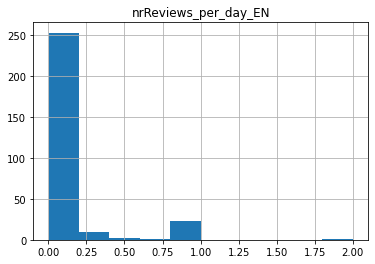

In [43]:
pizza.hist(column='nrReviews_per_day_EN');

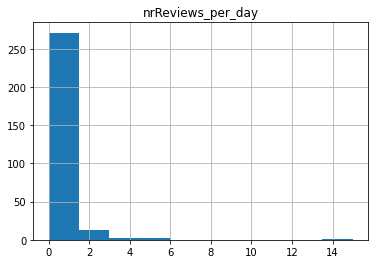

In [44]:
pizza.hist(column='nrReviews_per_day');

From the two histograms above it can clearly be seen that the majority of restaurants have very few reviews each day. However there is clearly an outlier when it comes to the **nrReviews_per_day**. When examining the data, it can be seen that the restaurant **Frankies Pizza Frederiksberg** has 15 reviews, but only one of them was in English. Therefore will the opening/closing date be estimated to be the same and all the reviews are counted as having happened on this single date. So it seems that for the popularity, it might be better to stick to the information from the English reviews.

In [45]:
pizza[pizza.nrReviews_per_day>10]

storeName  \
220  Frankies Pizza Frederiksberg   

                                          storeAddress  avgRating  nrReviews  \
220  Allegade 2, Frederiksberg, Copenhagen 2000 Den...        3.5         15   

     priceCategory CousineType all_ranks                  all_ratings  \
220            2.5     [Pizza]        []  [(Food, 3.0), (Value, 2.0)]   

           lat        lon                                           location  \
220  55.675014  12.532789  Frankies Pizza Frederiksberg, Frederiksberg Al...   

              area                                                 tf  \
220  Frederiksberg  {'amazing': 2, 'pizza': 2, 'recommend': 2, 'pl...   

                                               tf_norm  sentiment  \
220  {'amazing': 0.10526315789473684, 'pizza': 0.10...     0.9661   

    min_ratingDate max_ratingDate  nrReviews_per_day  nrReviews_EN  \
220     2020-03-01     2020-03-01               15.0             1   

     nrReviews_per_day_EN  
220                   1.0

>**Conclusion:** We have now generated simple estimators of popularity for the restaurants, and concluded that it is best for our analysis to focus on the **nrReviews_per_day_EN** popularity estimator.

<a id='market'></a>
 ![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)
# 3. Market analysis 📈

Now that the data has been prepared, it is possible to start the market analysis of the Pizza market in Copenhagen.

* [3.1 Cousine Types](#cousine)
* [3.2 Where are the pizza restaurants located?](#pizza_loc)
* [3.3 Differences between areas (neighbourhoods)](#diff_areas)
* [3.4 Evolution of distribution of pizza places](#heatmap)
* [3.5 Restaurant density](#density)
* [3.6 Restaurant density development](#density_development)
* [3.7 TF-IDF of review scores - What matters for a high review?](#tf-idf-reviews)
* [3.8 TF-IDF of popular pizzerias - What matters for popularity?](#popular_wordcloud)
* [3.9 Network analysis](#network)

![img](http://www.thatawesomeshirt.com/images/get/2985/430x550/)

<a id='cousine'></a>
## 3.1 Cousine Types 🍽

>**Mission**: Find out if the restaurants are 'advertising' themselves as pizza places, or if pizzas are simply on the menu, while the main cousine type is something else.

It's interesting to note that restaurants that offer pizzas, don't necessarily advertise themselves especially as pizzerias. When the CousineTypes of the restaurants are plotted in a bar chart, it can be seen that around half of the dataset is categorized as **Italian** or **Pizza**, while the rest has a broad variety of different categories.

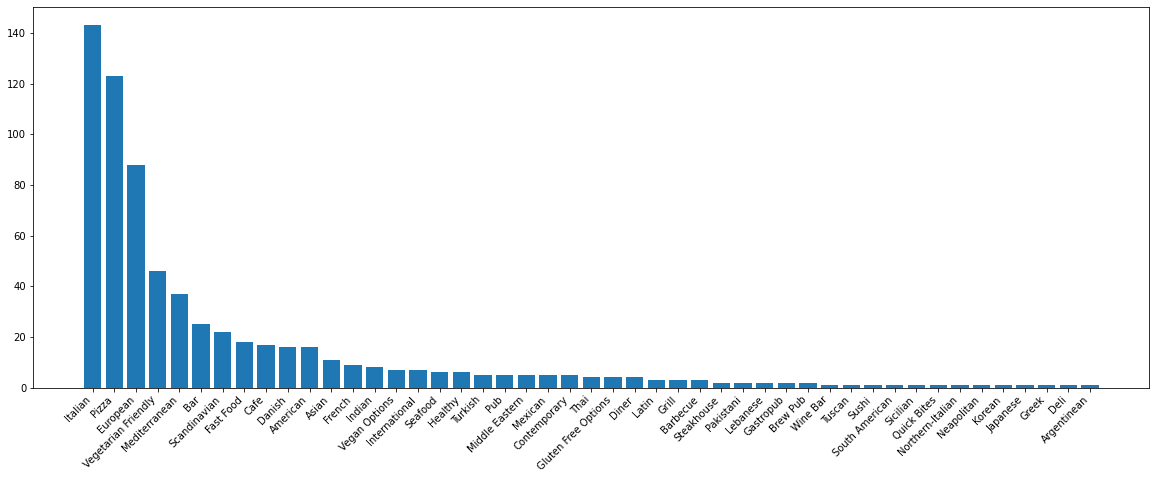

In [46]:
# https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
# https://stackoverflow.com/questions/49017002/bar-plot-based-on-list-of-string-values

CousineTypeFlat = [y for x in pizza.CousineType for y in x]

keys, counts = np.unique(CousineTypeFlat, return_counts=True)

counts, keys = zip(*sorted(zip(counts, keys), reverse=True))

plt.figure(figsize=(20,7))
plt.bar(keys, counts)
plt.xticks(rotation=45, ha='right')
plt.show()

In [47]:
# Generate a list marking if a restaurant is mainly italian/pizza
mainly_pizza = []

# For each restaurant, if they have Pizza as cousine type, pizz in the name or have a review with pizza - append 1
for idx, row in pizza.iterrows():
    if 'Pizza' in row.CousineType or 'pizz' in row.storeName.lower():
        mainly_pizza.append(1)
    else:
        mainly_pizza.append(0)
        
# Add new column to dataset
pizza['mainly_pizza'] = mainly_pizza

In [48]:
pizza['mainly_pizza'].value_counts()

0    147
1    142
Name: mainly_pizza, dtype: int64

Now there is a special column in the dataset with a binary classification of wheather or not pizzas are the main cousine of the restaurant.

In [49]:
pizza[['mainly_pizza','avgRating', 'nrReviews', 'priceCategory', 'sentiment', 'nrReviews_EN', 'nrReviews_per_day_EN']].groupby('mainly_pizza').agg('mean')

avgRating   nrReviews  priceCategory  sentiment  nrReviews_EN  \
mainly_pizza                                                                  
0              3.897959  262.598639       2.378049   0.651465    143.047619   
1              3.940141  100.408451       2.035398   0.605489     44.739437   

              nrReviews_per_day_EN  
mainly_pizza                        
0                         0.062858  
1                         0.190655

From the above summary table we can see that the pizzerias have a slightly higher average rating than the other restaurants. They are less expensive and have a slightly lower average sentiment. They have on average much fewer English reviews, but are however much more popular than the other restaurants, as they have a much higher number of English reviews per day.

> **Conclusion**: Around half of the restaurants in the dataset are specially categorized as pizza places, while the other half of the restaurants have a different main focus, but still offer pizza on the menu. So while the main competitors would be the restaurants classified as Pizzerias, there are still a lot of other restaurants that also offer pizzas, without categorizing themselves as Pizzerias. The pizzerias are more popular but still have a fewer number of total reviews than the other restaurants. The sentiment is lower for the Pizzerias but the average rating is higher. The pizzerias tend to be categorized cheaper than the other restaurants.

<a id='pizza_loc'></a>
## 3.2 Where are the pizza restaurants located? 💥

>**Mission**: Visualize where the pizza restaurants are located within the city.

Now it is possible to generate a plot of Copenhagen, showing where the pizza restaurants are located.

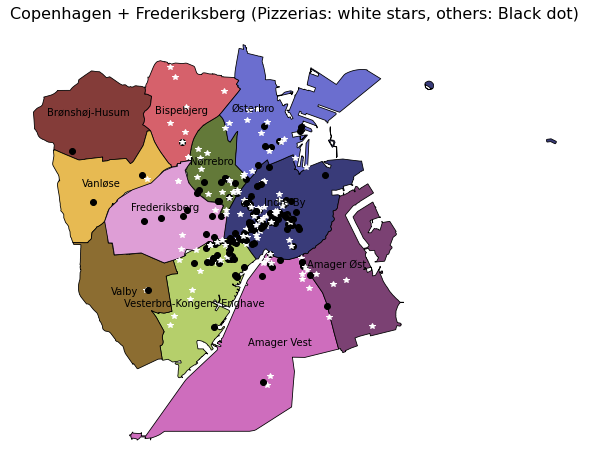

In [50]:
# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph.plot(column='id', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=False);
ax.axis('off');
ax.set_title('Copenhagen + Frederiksberg (Pizzerias: white stars, others: Black dot)', fontsize=16);

for idx, row in pizza.iterrows():
    if row.mainly_pizza == 0:
        ax.plot(row['lon'], row['lat'], markersize=6, marker='o', color='black')
    else:
        ax.plot(row['lon'], row['lat'], markersize=6, marker='*', color='white')

for idx, row in gdf_cph.iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

In the figure above, all of the restaurants in the dataset have been plotted on top of the different areas of Copenhagen. The **black dots** are restaurants that don't have Pizzas are their main Cousine Type, while the **white stars** are those restaurants that self-identify as Italian or Pizzerias.
>**Conclusion**: The distribution of both pizzerias and restaurants that offer pizzas, is mainly focused around the center of Copenhagen. The majority is in Indre By, and close to the edges of the neighbouring areas, mainly, Vesterbro, Nørrebro and Østerbro. There seem to be quite a few designated pizza places in Bispebjerg, compared to the other areas that are further from the center, that usually only have a single one, or just restaurants that offer pizzas.

<a id='diff_areas'></a>
## 3.3 Differences between areas (neighbourhoods) 🏙


>**Mission:** Analyze the differences between the CPH areas, with respect to the restaurants.

Let's further examine the difference between the areas (neighbourhoods) with respect to the pizza places.

In [51]:
# Group the dataset on the different areas
no_places = pizza.groupby('area').agg('count')['storeName']

areas = pizza.groupby('area').agg('mean')[['avgRating', 'nrReviews', 'priceCategory', 'sentiment', 'nrReviews_EN', 'nrReviews_per_day_EN', 'mainly_pizza']]

areas['no_places'] = no_places
areas.style.background_gradient(cmap='Reds')

The coloring of the cells tends not to show up when the Jupyter notebook is loaded again, so here is a photo:

![img](Images/areas1.png)

* The highest average rating is in Vanløse, but there are only 3 places there, so it might skew the results slightly to have such few places, however there is an average of 22 English reviews for each place so those seem to be doing well.
* Indre By and Vesterbro are without a doubt the most frequently visited areas, with the highest average number of reviews and also English reviews.
* Valby has the highest average price category, while Nørrebro has the lowest.
* Bispebjerg has the highest average sentiment and also has the highest ratio of restaurants that are mainly pizzerias.
* The lowest ratio of mainly pizza places is in Brønshøj where there is only a single restaurant that serves pizza, and no restaurant that is mainly a pizzeria.

But let's look at this again without the areas that have a very few number of places. 

In [52]:
areas[areas.no_places>10].style.background_gradient(cmap='Reds')

The coloring of the cells tends not to show up when the Jupyter notebook is loaded again, so here is a photo:

![img](Images/areas2.png)
Here the comparison is slightly more "fair" as these areas all have a decent number of places. 
* The highest average rating is now on the pizza places in Frederiksberg, followed by Nørrebro, but Vesterbro comes in last place.
* The highest average number of reviews are in Vesterbro and Indre By, and they are almost twice as many as the areas following.
* Østerbro has the highest average price Category, while Nørrebro has by far the lowest.
* The sentiments are distributed relatively evenly, but the highest value is still in Frederiksberg, with the lowest ones being in Østerbro.
* The most popular places are in Østerbro, followed by Vesterbro and the least popular are in Amager Vest.
* Vesterbro and Indre By have the lowest ratios of mainly pizzerias, but the highest number of restaurants in total.

Now lets look at each area as a whole
* **Amager Vest** has the lowest popularity and number of rebiews scores. There are 25 restaurants there and just over half of them are Pizzerias. The prices are the second lowest, and the sentiment and average rating are in the mid ranges.
* **Frederiksberg** Frederiksberg has the highest sentiment and the highest number of reviews. There are only 18 places located there, around half of them are Pizzerias. However these restaurants don't score too high on the popularity, around mid range there. The restaurants are also around mid way in prices.
* **Indre By** has the highest number of places 119. It has the most reviews, but is actually not that popular area based on the popularity indicator. The sentiment is among the highest, but the price is also among the highest ones. The average ratings are in the lower range. There are around 40% of the restaurants there that are mainly pizzerias.
* **Nørrebro** Has a very high rating and high sentiment, while having the lowest price category. Over half of the restaurants are classified as pizzerias, and they are around midrange in popularity.
* **Vesterbro** Has the lowest average rating, the second lowest sentiment, but is still very popular. It is the area with by far the lowest ration of Pizzerias, while still having a high number of restaurants. It's less expensive than Indre By and Østerbro, but way more expensive than Nørrebro.
* **Østerbro** is the most expensive and most popular area. It has 20 places, with 65% of them being Pizzerias. However it has the lowest average sentiment and average rating in the mid range.


### Visualization of the differences - Popularity
Now the data for the main six areas will be visualized using the shapefiles, to give a clearer picture of the differences between the areas. Since the table above gives a good overview of all the different values, the visualization will only be done for the popularity measure.

In [53]:
# Drop the index on area and merge the two datasets together
areas = areas.reset_index()

# Merge the counts into the dataframe
gdf_cph = pd.merge(gdf_cph, areas, left_on='navn', right_on='area', how='left')

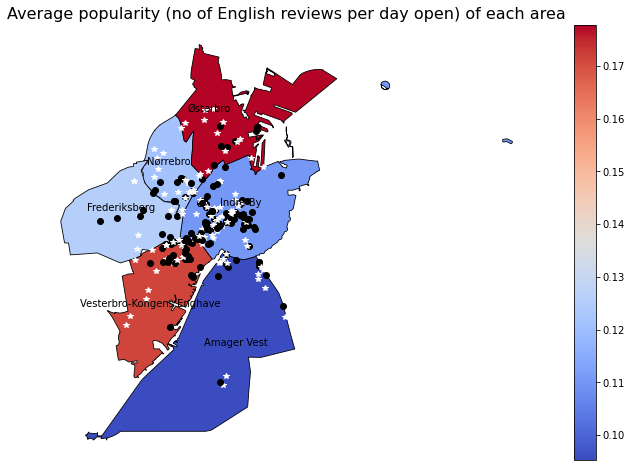

In [54]:
# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph[gdf_cph.no_places>10].plot(column='nrReviews_per_day_EN', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Average popularity (no of English reviews per day open) of each area', fontsize=16);

for idx, row in pizza.iterrows():
    if row.area in set(gdf_cph[gdf_cph.no_places>10].navn): # only plot relevant areas
        if row.mainly_pizza == 0:
            ax.plot(row['lon'], row['lat'], markersize=6, marker='o', color='black')
        else:
            ax.plot(row['lon'], row['lat'], markersize=6, marker='*', color='white')

for idx, row in gdf_cph[gdf_cph.no_places>10].iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

Here we can see visually which areas where investigated in more detail. Here it is clear that Østerbro and Vesterbro are the most popular areas, With Frederiksberg being the least popular of those.

>**Conclusion:** The different areas of Copenhagen display different characteristics, and depending on what type of Pizzeria the clients want to open the recommendations could be different. However as a general guideline we would receommend looking first at opening a restaurant in Vesterbro. 

>**Vesterbro** Has the lowest average rating, the second lowest sentiment, but is still very popular. It is the area with by far the lowest ratio of Pizzerias, while still having a high number of restaurants. It's less expensive than Indre By and Østerbro, but way more expensive than Nørrebro. 

>The client is interested in opening up a new Pizza place. If this place would be positioned in Vesterbro, then it would be surrounded mainly by restaurants that serve pizzas but are not classified as Pizzeries. As shown in [3.1 Cousine Types](#cousine) the popularity of pizzerias is much higher than the popularity of the other types of restaurants, so we would be positioning ourselves in a really popular area, that has a low ratio of pizzerias, low average scores and sentiment values. By opening up a great new pizza place that would generate a high sentimental value and average rating, the place would stick out from the average crowd of other restaurants. We would also be able to position ourselves in a pretty high Price Category, but would have the option of offering cheaper food, in hopes of the sentiment and reviews being higher, given that the food is a great value for the price. 

<a id='heatmap'></a>
## 3.4 Evolution of distribution of pizza places 📊
>**Mission**: Use the open/close dates and plot a heatmap with timeseries, showing locations of restaurants that are open in each year, from 2007-2021. This will show how the distribution of restaurants changes and perhaps show some trends.

Now the dataset contains estimated information about when each restaurant opened and closed. From that it is possible to generate a heat map, showing which restaurants were open in each year, and where they were located. For this we will use **Folium**

In [55]:
# Generate a list of all the years restaurants were active
year_list = sorted(pizza.min_ratingDate.dt.year.unique())

locations_years = []

# For each year, check which restaurants were active and add these coordinates to a list
for year in year_list:
    # Find open restaurants locations
    list_for_year = pizza[(pizza.min_ratingDate.dt.year <= year) & (pizza.max_ratingDate.dt.year >= year)][['lat', 'lon']]
    list_for_year = list_for_year.dropna()
    list_for_year = list_for_year.values.tolist() # generate list of lists
    locations_years.append(list_for_year)

In [95]:
#https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data
# Generate map
map = folium.Map(location=[55.68, 12.6], zoom_start=12)
# Add heatmap with time
plugins.HeatMapWithTime(data=locations_years, min_opacity=0, auto_play=True, index=year_list, radius=20).add_to(map)
map

The plot starts with just a single restaurants in 2007, but in 2008 there appear to be a hotspot starting in Indre By, with a few places opening up in the neighbouring areas, like Frederiksberg and Vesterbro. In 2009 the hotspot in Indre By grows, and additional places pop up in the neighbouring areas. The center hotspot keeps growing until 2013, when it has connected to the neighbouring areas, Vesterbro, Frederiksberg, Nørrebro and the most south areas of Amager. Until 2016 the growth of the centering hotspot expands North-West, more towards Nørrebro, while also reaching slightly more towards Østerbro. Until 2019, the graph changes very little, with some areas shifting sligthly but the hotspot covering very similar area as before. From 2019-2020 it seems that many of the restaurants in the outskirts have closed down, as the outliers seem to be fewer in the map. Finally of course in 2021 only a small part of the restaurants appear on the map because of COVID. 

>**Conclusion**: Most of the restaurants are and have been focused around the center. Some restaurants further from the center pop up every now and then, but it seems that many of them have closed down in 2020, or simply cater more towards locals instead of turists, which would explain why they are less prominent in the dataset. The business for restaurants offering pizzas still seems to be pretty thriving, given the number of those places. But these places took a major hit in COVID, which can partly be explained by the lockdown in Denmark, which only allowed the places to offer take-away. Another reason for a lack of restaurant reviews in 2021, is that the dataset only contains English reviews, but because of Covid, the majority of customers during this periods, must have been Danish, and their reviews would most likely be written in Danish.

<a id='density'></a>
## 3.5 Restaurant density in areas 👩‍🍳
>**Mission:** Analyse the density of restaurants for each area.

So which areas contain the highest density of pizza restaurants, and how much differences are there between different areas?

Let's add the population data for 2021 Q2 for each area, found [here](https://kk.statistikbank.dk/statbank5a/default.asp?w=1536). For Frederiksberg the population data for 2021 Q1 was found [here](https://www.statistikbanken.dk/statbank5a/selectvarval/saveselections.asp).

In [57]:
# Order: Norrebro, Brønshøj-Husum, Bispebjerg, Amager Vest, Vanlose, Indre By, Amager Ost, Osterbro, Vesterbro, Valby, frb
population = [79000, 44230, 54086, 82076, 40774, 56253, 60907, 79912, 75166, 62549, 103677]

# Add population data to the shapefile
gdf_cph['population'] = population

Now we have added the population data for each area from the above sources.

In [58]:
gdf_cph.head(3)

id  bydel_nr            navn   areal_m2  \
0   3       3.0        Nørrebro  4107635.0   
1   7       7.0  Brønshøj-Husum  8740778.0   
2   8       8.0      Bispebjerg  6830467.0   

                                            geometry  \
0  POLYGON ((12.53704 55.69653, 12.53736 55.69661...   
1  POLYGON ((12.46894 55.69975, 12.46698 55.70024...   
2  POLYGON ((12.53830 55.72644, 12.53846 55.72640...   

                                     coords            area  avgRating  \
0   (12.549241539645678, 55.69645459537336)        Nørrebro   4.140625   
1  (12.482828842919833, 55.711140597352085)  Brønshøj-Husum   4.000000   
2  (12.532852286152643, 55.711662618606745)      Bispebjerg   3.950000   

   nrReviews  priceCategory  sentiment  nrReviews_EN  nrReviews_per_day_EN  \
0   99.28125       1.923077   0.645795       47.3125              0.121157   
1    6.00000            NaN   0.362420        5.0000              0.006112   
2   33.70000       2.125000   0.739483       12.3000              0.008974   

   mainly_pizza  no_places  population  
0        0.5625         32       79000  
1        0.0000          1       44230  
2        0.9000         10       54086

Then we can calculate the ratios and display them with the shapefiles.

In [59]:
# Calculate the counts for each area given 
all_restaurants = pizza.groupby('area').agg('count')['storeName']

# Merge the counts into the dataframe
gdf_cph = pd.merge(gdf_cph, all_restaurants, left_on='navn', right_on='area', how='left')
gdf_cph = gdf_cph.rename(columns={"storeName": "total_count"})

# Fill NaN with zeros
gdf_cph = gdf_cph.fillna(0)

# Calculate ratios for restaurants for population/area
gdf_cph['area_ratio_restaurant'] = gdf_cph['total_count'] / gdf_cph['areal_m2']
gdf_cph['pop_ratio_restaurant'] = gdf_cph['total_count'] / gdf_cph['population']

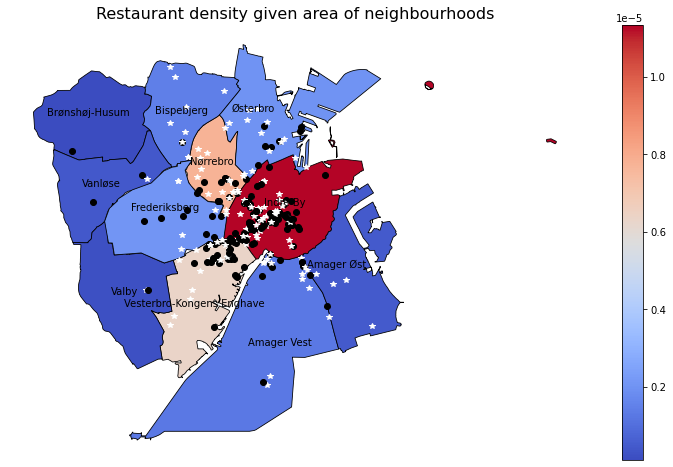

In [60]:
# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph.plot(column='area_ratio_restaurant', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Restaurant density given area of neighbourhoods', fontsize=16);

for idx, row in pizza.iterrows():
    if row.mainly_pizza == 0:
        ax.plot(row['lon'], row['lat'], markersize=6, marker='o', color='black')
    else:
        ax.plot(row['lon'], row['lat'], markersize=6, marker='*', color='white')

for idx, row in gdf_cph.iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

> The plot above shows the density of restaurants given the area(m^2) of the neighbourhoods. Here it is clear the Indre By has by far the highest one, followed by Nørrebro and then Vesterbro. The other areas are much lower in density.

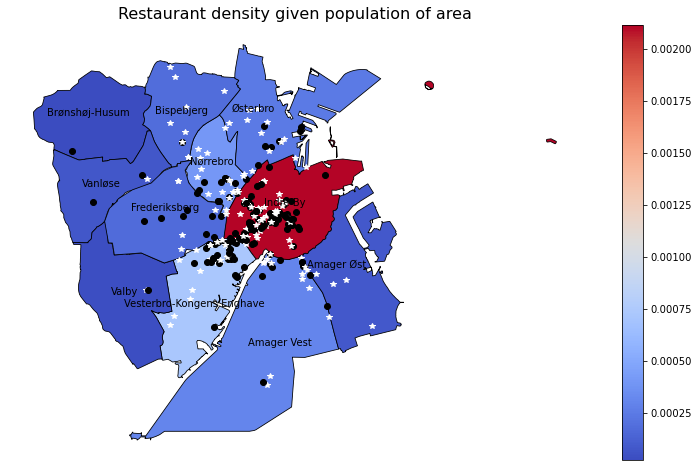

In [61]:
# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph.plot(column='pop_ratio_restaurant', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='black', legend=True);
ax.axis('off');
ax.set_title('Restaurant density given population of area', fontsize=16);

for idx, row in pizza.iterrows():
    if row.mainly_pizza == 0:
        ax.plot(row['lon'], row['lat'], markersize=6, marker='o', color='black')
    else:
        ax.plot(row['lon'], row['lat'], markersize=6, marker='*', color='white')

for idx, row in gdf_cph.iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

> Not surprisingly the density of restaurants is highest in Indre By, given the population of the area. Alot of people live in Indre By and the restaurant selection there is the greatest one. The same areas as before come in second and third place, namesly Vesterbro and Nørrebro. 

>**Conclusions:** The density is by far highest in Indre By both given area(m^2) and population. Vesterbro and Nørrebro come in second and third place. 

<a id='density_development'></a>
## 3.6 Restaurant count development 🕵️‍♀️

>**Mission:** See the development of the number of pizza places staying open in each area.

So where are new places opening up or closing down in each year?
In order to examine this the number of open places for each year was computed, and the data groupped on the area.
In order for the graphs to be clearer, the areas containing less than six places are excluded.

In [62]:
# get the minimum and maximum year of the dataset
year_from = min(pizza.min_ratingDate.dt.year)
year_to = max(pizza.max_ratingDate.dt.year)

# Generate a dataframe to gather the results in
areas_years = pd.DataFrame(pizza.groupby('area').agg('count')['storeName'])

# Let's only look at the areas that have over five places.
areas_years = areas_years[areas_years.storeName > 10]

In [63]:
# Loop through all years
for i in range(year_from, year_to+1):
    # generate a count of how many restaurants were open in that year for each area.
    df = pizza[(pizza.min_ratingDate.dt.year <= i) & (pizza.max_ratingDate.dt.year >= i)].groupby('area').agg('count')['storeName']
    # Add to the dataframe
    areas_years[str(i)] = df
# delete the total count of restaurants
del areas_years['storeName']

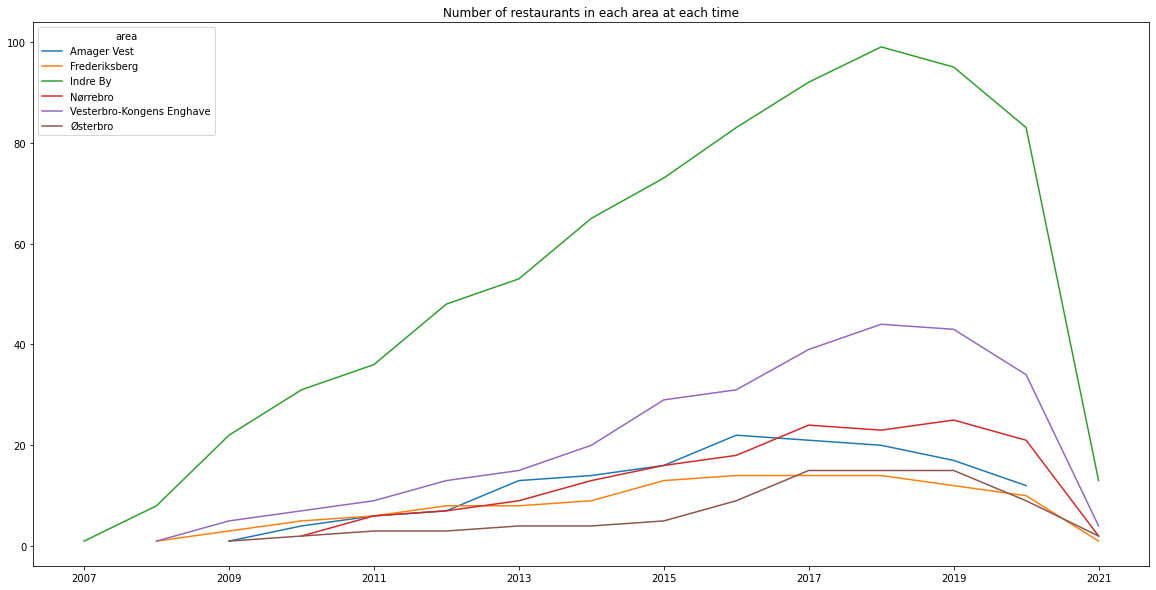

In [64]:
areas_years.T.plot(figsize=(20,10), title="Number of restaurants in each area at each time");

From the figure above we can see that Indre By both has the highest number of open restaurants at any given time, and also had the steepest slope, that is more open restaurants each year. It's also the area that has suffered the highest number of closures between years, after COVID hit. 
Vesterbro follows a similar curve as Indre By just to a lower degree.  The rest of the areas follow a pretty similar courve, with the exception that the decline in Amager Vest started in 2016, but in 2018-2019 for the other areas.

Lets examine the differences in the number each year.

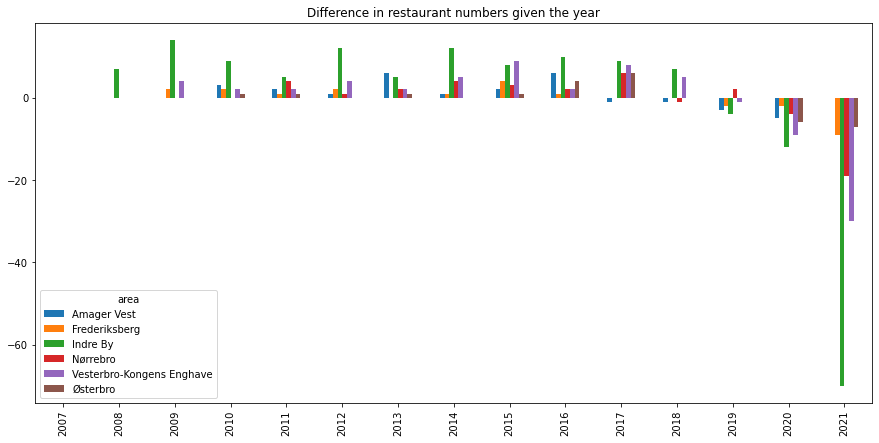

In [65]:
areas_years.T.diff().plot(figsize=(15,7), title="Difference in restaurant numbers given the year", kind='bar');

If we look at the differences between the number of places open each year, some interesting patterns emerge. Most of the areas have a pretty stable number of increases/decreases between the years, but the values for Indre By fluctuate quite a lot between different years. Let's keep in mind that they are almost always increasing, but they increase much less in the years, 2011 and 2013, compared to 2009, 2012 and 2014. 
The "closures" because of COVID, starting in 2020 and continuing in 2021 affect the scale of the image in a great way, so lets exclude 2021 and draw the figure again.

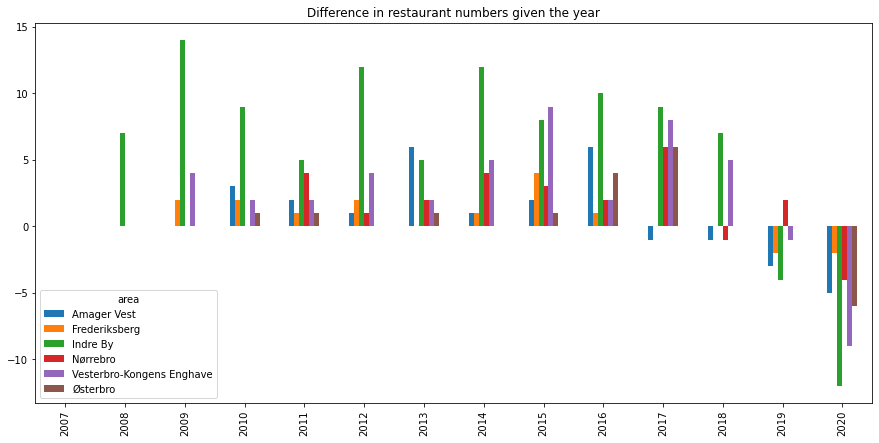

In [66]:
areas_years[['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']].T.diff().plot(figsize=(15,7), title="Difference in restaurant numbers given the year", kind='bar');

Now we can see even clearer the fluctuation in the number of places opening um in Indre By. It is clear the the pizza market has been growing and expanding ever since 2007 and until 2017, there were always a higher number of places opened compared to last year. Things start taking a turn for the worse after 2017, where the number of restaurants stays the same for two areas, Frederiksberg and Østerbro, and decreases for Amager Vest and Nørrebro. In 2019 there were decreases in the number of restaurants in four areas, compared to the year before. Those areas are Amager Vest, Frederiksberg, Indre By and Vesterbro. Østerbro has the same number of restaurants as the year before.

**Conclusions:** The pizza market has expanded considerably with Indre By leading the way and Vesterbro following closely behind. The market was expanding rapidly from 2007-2017, but after that there is a decline in the slope and in some cases there are declines in the number of open pizza places each year. The industry took a big hit when because of COVID starting in 2020. However there was already a decline before COVID, because the restaurants that were open at the start of 2020 count as having been open the entire year of 2020. But because of the market condititions and uncertainty there might have been fewer new places opening up, than usually. Given that the financing of the client's new Pizza place is secure, there are definately some opportunities in the market now, with there being fewer competitors than normally.

<a id='tf-idf-reviews'></a>
## 3.7 TF-IDF of review scores - What matters for a high review? 🥇
>**Mission:** Use TF-IDF to analyse what words are most distinctive for different review ratings.

Here we will use the pizza dataset and group the reviews having the same score together.

In [67]:
# Find all restaurants that are actually pizzerias
pizzeria_list = pizza[pizza.mainly_pizza == 1].storeName

# Find all restaurants that have the word 'pizza' and mark those with 1
reviews['pizza_review'] = reviews.apply(lambda x: 1 if x.tf['pizza'] == 1 or x.storeName in pizzeria_list else 0, axis=1)

# Create a new pizzas_review list 
pizza_reviews = reviews[reviews.pizza_review==1].reset_index(drop=True)

# Generate a new dataframe with only the pizza reviews
review_scores = pd.DataFrame(pizza_reviews.groupby('rating')['tf'].agg('sum'))
review_scores

tf
rating                                                   
1       {'poor': 11, 'service': 57, 'place': 36, 'tota...
2       {'overall': 4, 'experience': 11, 'dreadful': 2...
3       {'good': 165, 'value': 11, 'money': 2, '...': ...
4       {'nice': 231, 'cozy': 20, 'little': 61, 'place...
5       {'em': 1, 'user': 1, 'group': 17, 'long': 31, ...

Now the Term Frequency distribution of each review score can be used to generate both a normalized Term Frequency distribution, and the Term Frequency - Inverse Document Frequency distribution for each rating.

In [68]:
# Generate a deep copy of the frequency distribution we currently have for each score
review_scores['tf_norm'] = review_scores.apply(lambda x: copy.deepcopy(x.tf), axis=1)

# For each restaurant
for idx, r in review_scores.iterrows():
    
    if pd.isna(r.tf):
        break
    
    # Calculate the number of words in the tf
    total = sum(r.tf.values())
    
    # for each word in the tf_norm
    for word in r.tf:
        r.tf_norm[word] = r.tf[word] / total

In [69]:
# Generate a deep copy of the frequency distribution we currently have for each review score
review_scores['tf-idf'] = review_scores.apply(lambda x: copy.deepcopy(x.tf), axis=1)

# Generate the tf-idf for each term for each review score, treating the corpus as the scores

# The total number of "documents" i.e. restaurants
N = len(review_scores)

# Loop through all the restaurants
for idx, r in review_scores.iterrows():
    
    # For each word in the restaurants tf
    for word in r.tf:
        res_count = 0 # reset the restaurant count
        
        # For each restaurant 
        for idx2, r_inner in review_scores.iterrows():
            
            if word in r_inner.tf.keys(): # if the word excists for that restaurant -> increase restaurant counter
                res_count += 1
        
        # Calculate the tf-idf of the word
        r['tf-idf'][word] = r['tf-idf'][word] * (math.log(N / (res_count)))

In [70]:
review_scores

tf  \
rating                                                      
1       {'poor': 11, 'service': 57, 'place': 36, 'tota...   
2       {'overall': 4, 'experience': 11, 'dreadful': 2...   
3       {'good': 165, 'value': 11, 'money': 2, '...': ...   
4       {'nice': 231, 'cozy': 20, 'little': 61, 'place...   
5       {'em': 1, 'user': 1, 'group': 17, 'long': 31, ...   

                                                  tf_norm  \
rating                                                      
1       {'poor': 0.0027728762288883285, 'service': 0.0...   
2       {'overall': 0.0011490950876185005, 'experience...   
3       {'good': 0.023424190800681432, 'value': 0.0015...   
4       {'nice': 0.01385141212448282, 'cozy': 0.001199...   
5       {'em': 4.0759761962990134e-05, 'user': 4.07597...   

                                                   tf-idf  
rating                                                     
1       {'poor': 0.0, 'service': 0.0, 'place': 0.0, 't...  
2       {'overall': 0.0, 'experience': 0.0, 'dreadful'...  
3       {'good': 0.0, 'value': 2.4545790644563072, 'mo...  
4       {'nice': 0.0, 'cozy': 10.216512475319814, 'lit...  
5       {'em': 1.6094379124341003, 'user': 1.609437912...

Now are the TF-IDF frequencies ready to be used to compute wordclouds for each review score.

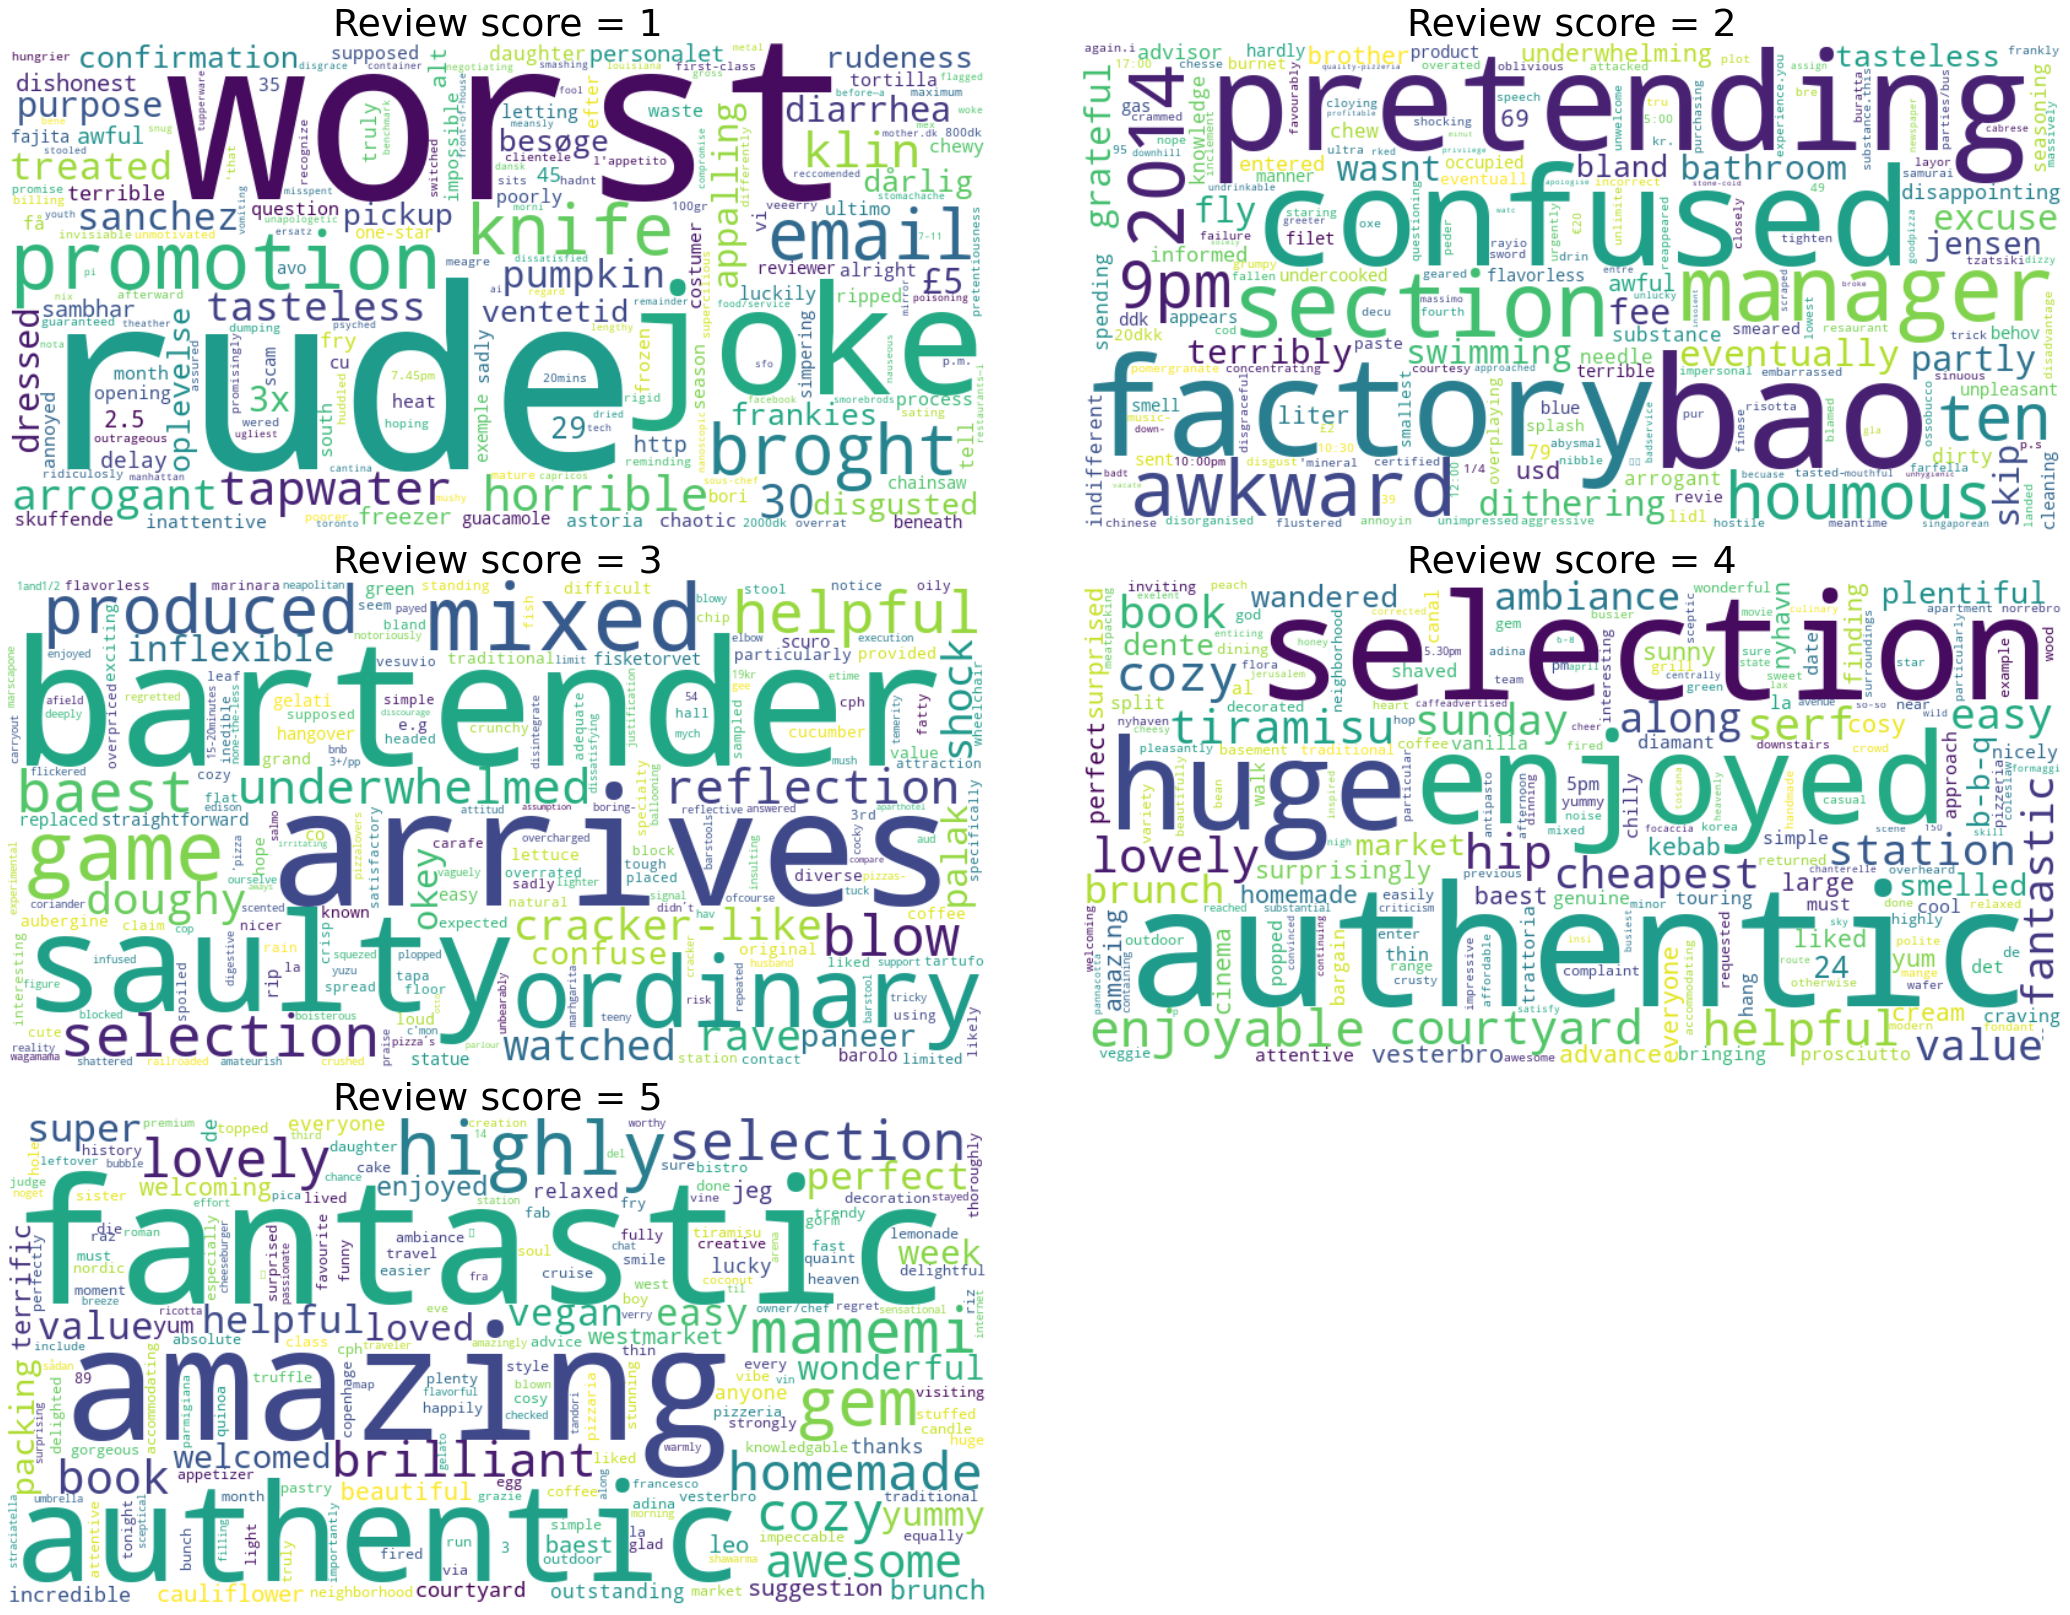

In [71]:
# From an old project of mine: https://nbviewer.jupyter.org/github/kristin14/hello-world/blob/master/Explainer_notebook_final.ipynb#3-1-3-tfidf

# Collect the word cloud objects into a dictionary
wordclouds = {}

for idx, score in review_scores.iterrows():
    
    wordclouds[idx] = WordCloud(collocations=False, 
                                             background_color='White', 
                                             width=800, 
                                             height=400, 
                                             colormap="viridis",
                                             random_state=42
                                             #stopwords = manual_stopwords  ### this does not work with generate_from_frequencies
                        ).generate_from_frequencies(score['tf-idf'])

# Generate a single figure
plt.figure(figsize=(30,30))

for idx, community_number in enumerate(wordclouds):
    plt.subplot(4, 2, idx+1);
    plt.imshow(wordclouds[idx+1], interpolation='bilinear');
    plt.title('Review score = ' + str(idx+1), size = 38);
    plt.tight_layout();
    plt.axis("off");

>**Conclusion**: Similarly to what was analyzed in **Business Question 1** the high review scores indicate that some important features of the restaurants scoring well are related to the words **fantastic**, **amazing**, **selection**, **authentic** and **enjoyed**. The lower scores more distinctly have words with a more negative meaning, such as **worst**, **rude**, **joke**, **pretending** and **confused**.

<a id='popular_wordcloud'></a>
## 3.8 TF-IDF of popular pizzerias - What matters for popularity? 🏆


>**Mission:** Use the popularity estimates and TF-IDF analysis to figure out what the popular restaurants are doing differently.

Similarly to what was done before, a TF-IDF can be generated for each restaurant. It will then show what words are most distinctive and common for each restaurant. This will show what makes each restaurant different from the rest, and can help us gain an understanding of what is needed to open up a popular restaurant.

In [72]:
#### WARNING
#### Takes around 8 minutes to run

# Filter on only the actual pizzerias in the dataset
pizzeria = pizza[pizza.mainly_pizza == 1]

# Generate a deep copy of the frequency distribution we currently have for each review score
pizzeria['tf-idf'] = pizzeria.apply(lambda x: copy.deepcopy(x.tf_norm), axis=1);

# Generate the tf-idf for each term for each review score, treating the corpus as the scores

# The total number of "documents" i.e. restaurants
N = len(pizzeria)

# Loop through all the restaurants
for idx, r in pizzeria.iterrows():
    
    # For each word in the restaurants tf
    for word in r.tf:
        res_count = 0 # reset the restaurant count
        
        # For each restaurant 
        for idx2, r_inner in pizzeria.iterrows():
            
            if word in r_inner.tf.keys(): # if the word excists for that restaurant -> increase restaurant counter
                res_count += 1
        
        # Calculate the tf-idf of the word
        r['tf-idf'][word] = r['tf-idf'][word] * (math.log(N / (res_count)));

<ipython-input-72-f1053e0cb890>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizzeria['tf-idf'] = pizzeria.apply(lambda x: copy.deepcopy(x.tf_norm), axis=1);


In [73]:
# Generate a list of different top locations
# Based on popularity
top_6_pop = pizzeria[pizzeria.nrReviews_EN>5].sort_values('nrReviews_per_day_EN', ascending=False).head(6).reset_index(drop=True)

# Based on average rating
#top_6_rating = pizzeria[pizzeria.nrReviews_EN>5].sort_values('avgRating', ascending=False).head(6).reset_index(drop=True)

# Based on sentiment
#top_6_sentiment = pizzeria[pizzeria.nrReviews_EN>5].sort_values('sentiment', ascending=False).head(6).reset_index(drop=True)

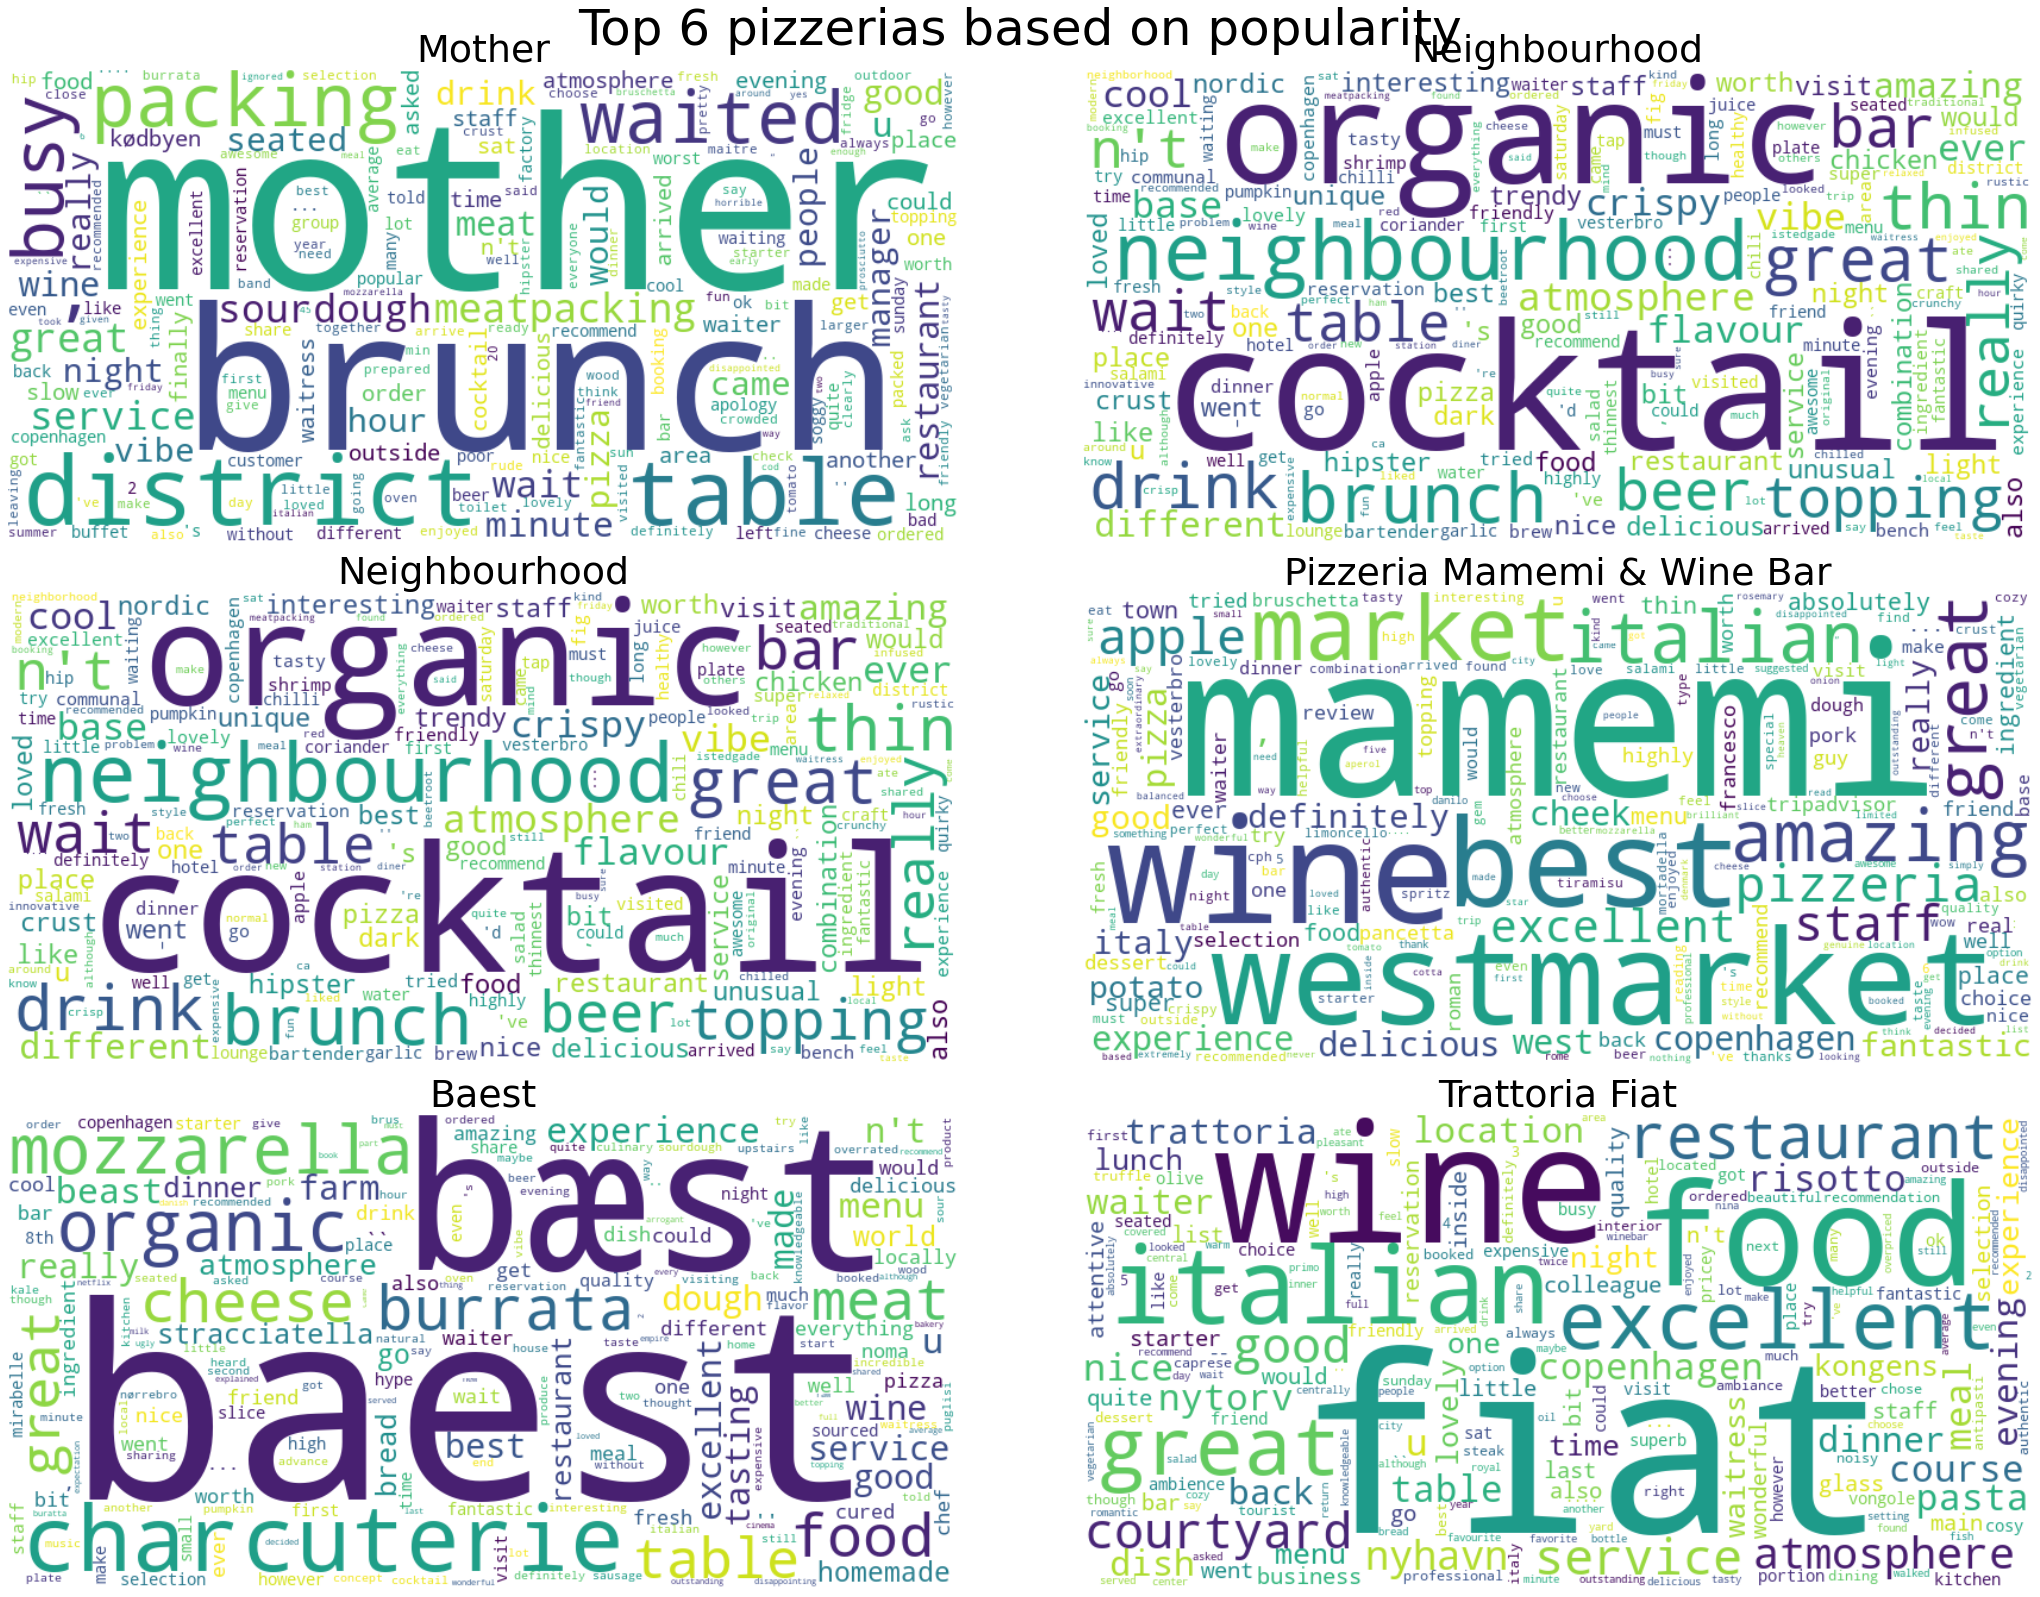

In [74]:
# From an old project of mine: https://nbviewer.jupyter.org/github/kristin14/hello-world/blob/master/Explainer_notebook_final.ipynb#3-1-3-tfidf

# Collect the word cloud objects into a dictionary
wordclouds = {}

for idx, row in top_6_pop.iterrows():
    
    wordclouds[idx] = WordCloud(collocations=False, 
                                             background_color='White', 
                                             width=800, 
                                             height=400, 
                                             colormap="viridis",
                                             random_state=42
                                             #stopwords = manual_stopwords  ### this does not work with generate_from_frequencies
                        ).generate_from_frequencies(row['tf-idf'])

# Generate a single figure
plt.figure(figsize=(30,30))

names = top_6_pop.storeName

for idx, community_number in enumerate(wordclouds):
    plt.subplot(4, 2, idx+1);
    plt.imshow(wordclouds[idx], interpolation='bilinear');
    plt.suptitle('Top 6 pizzerias based on popularity', size = 50)
    plt.title(names[idx], size = 38);
    plt.tight_layout();
    plt.axis("off");

From the wordcloudes above we notice some interesting things. First of all we spot that Neighbourhood appears twice. This can be explained in the next cell. If we focus first on **Mother** we can see that some of the most distinctive words there are **brunch**, **packing**, **district**. It seems that Mothers offers a popular Brunch, and is located in the Meat Packing District in Vesterbro. 
From Mothers homepage we can find the following about their brunch:


![img](Images/mother_brunch.png)


If we shift our focus to **Neighbourhood** the main words there are **cocktail** and **organic**. These are both things that the company puts emphasis on in their advertising, as can be seen in the Google search results


![img](Images/neighbourhood_google.png)


**Pizzeria Mamemi & Wine Bar** has a big emphasis on **wine** and **westmarket**. The name includes Wine Bar so clearly they put emphasis on that in their own marketing and offerings. **westmarket** relates to the location, but the place was located close to that Food court.
**Bæst** has the main focus on it's own name, followed by **charcuterie**, **organic** and **mozzarella**. When looking at their homepage we came across this information:


![img](Images/baest.png)


so it seems fitting that these words would be prominent in the wordclouds.
**Trattoria Fiat** Has more general words, but we can see that some of the main ones are **italian**, **courtyard** and **atmosphere**. When looking at their Facebook, they put a lot of focus on showing how great the atmosphere is in their courtyard.


![img](Images/trattoria.png)

There are two Neighbourhood places, one located in Jaegersborggade (Nørrebro) and the other one in Istedgade (Vesterbro). But because of how the scraping was performed, there is no way to distinguish which reviews are for which location. So both restaurants will have the same features even if the main location is clearly in Vesterbro. This is something that could be improved in the way the data was scraped, if the project were to be repeated.

In [75]:
top_6_pop[top_6_pop.storeName == 'Neighbourhood']

storeName                                 storeAddress  avgRating  \
1  Neighbourhood  Jaegersborggade 56, Copenhagen 2200 Denmark        5.0   
2  Neighbourhood        Istedgade 27, Copenhagen 1650 Denmark        4.0   

   nrReviews  priceCategory                 CousineType  \
1          7            2.5       [Italian, Bar, Pizza]   
2        750            2.5  [Italian, Pizza, European]   

                                           all_ranks  \
1  [#129 of 238 Italian in Copenhagen, #929 of 1,...   
2  [#13 of 238 Italian in Copenhagen, #126 of 1,9...   

                                         all_ratings        lat        lon  \
1                                                 []  55.670623  12.558379   
2  [(Food, 4.5), (Service, 4.0), (Value, 4.0), (A...  55.670623  12.558379   

   ...                                                 tf  \
1  ...  {'copenhagen': 102, 'dining': 13, 'week': 8, '...   
2  ...  {'copenhagen': 102, 'dining': 13, 'week': 8, '...   

                                             tf_norm sentiment min_ratingDate  \
1  {'copenhagen': 0.006412271327088703, 'dining':...  0.769238     2014-09-23   
2  {'copenhagen': 0.006412271327088703, 'dining':...  0.769238     2014-09-23   

   max_ratingDate nrReviews_per_day nrReviews_EN  nrReviews_per_day_EN  \
1      2020-10-26          0.003145          489              0.219677   
2      2020-10-26          0.336927          489              0.219677   

   mainly_pizza                                             tf-idf  
1             1  {'copenhagen': 0.002510268708468555, 'dining':...  
2             1  {'copenhagen': 0.002510268708468555, 'dining':...  

[2 rows x 22 columns]

Lets look at the locations of those most popular places.

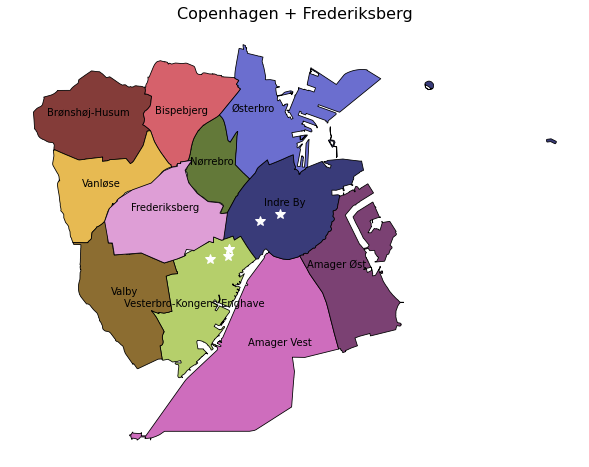

In [76]:
# Plot the shapefiles
fig, ax = plt.subplots(1, figsize=(14, 8));
gdf_cph.plot(column='id', cmap='tab20b', linewidth=0.8, ax=ax, edgecolor='black', legend=False);
ax.axis('off');
ax.set_title('Copenhagen + Frederiksberg', fontsize=16);

for idx, row in top_6_pop.iterrows():
    if row.mainly_pizza == 0:
        ax.plot(row['lon'], row['lat'], markersize=10, marker='o', color='black')
    else:
        ax.plot(row['lon'], row['lat'], markersize=10, marker='*', color='white')

for idx, row in gdf_cph.iterrows():
    plt.annotate(text=row['navn'], xy=row['coords'],
                 horizontalalignment='center', color='black')

>**Conclusions:** The post popular pizzerias are located in Indre By and Vesterbro. All of the top 5 most popular places make sure to distinquish themselves from their competitors by offering something unique. In some cases it can be great cocktails, in others great wine, or a unique outdoor area. Some put more emphasis on the materials used being organic or even homemade. But it is clear that each one made sure to state clearly what they wanted to be best known for.

<a id='network'></a>
## 3.9 Network Analysis of the Pizza Market 🍕

>**Mission:** Analyse the network of the pizza market, the relationship between reviewer and restaurant. Analyze which places and reviewers can be groupped together into communities, find out which users have most influence.

The first thing added here is additional information about the reviewers, lets call them users for clarity and less confusion with the reviews themselves. The dataset contains information about the the location of the reviewer, when they joined, number of contibutions, reviews, upvotes, followers and which other users this user follows.

In [77]:
# read in the info on users
users = pd.read_csv('Data/all_reviewer_info.csv')
users.sample(3)

username                   location              joined  \
17565  LloydMason-Edwards      Leeds, United Kingdom  Joined in Oct 2007   
17109             nilledk        Copenhagen, Denmark  Joined in Aug 2011   
5418               zara06  San Francisco, California  Joined in Jun 2008   

       nrContributions  nrReviews  nrUpvotes  nrFollowers followers  \
17565               77         75         56            2        []   
17109               83         32         33            0        []   
5418                79         79         15            0        []   

       nrFollowing following  
17565            0        []  
17109            0        []  
5418             0        []

Then we generate a list of all the reviewers, and use all the restaurants to generate a graph showing all the reviewers and which restaurants they have reviewed. Then a network is built using this data. 
The network shows all the reviewers and restaurants in the dataset, where each reviewer and restaurant is a node, and the rating the user has given the restaurant is an edge. Both the nodes and edges have attributes that come from the datasets we have generated before.

In [78]:
reviewer_list = list(reviews['reviewerUsername'].unique())

In [79]:
# Create new graph
G = nx.Graph()

# Add each restaurant and 
for idx, r in pizza.iterrows():
    
    nr_reviews = r.nrReviews #pizza[pizza.storeName == r].nrReviews.reset_index()['nrReviews'][0]
    
    if r.mainly_pizza == 1:
        kind = 'Pizzeria'
    else:
        kind = 'Restaurant'

    G.add_node(r.storeName, kind=kind, nrReviews = nr_reviews)

nr_reviews = reviews.groupby('reviewerUsername').agg('count')['storeName']        
# Add all the reviewers as reviewers
for r in reviewer_list:
    nr = nr_reviews[r]
    G.add_node(r, kind='Reviewer', nrReviews = nr)

#print("Number of nodes: ", len(G.nodes()))    
    
# Add all the edges between restaurants and reviewers, only those in the sets
# Let's add edge information as well
for idx, row in reviews.iterrows():
    if (row.reviewerUsername in reviewer_list):
        G.add_edge(row.storeName, row.reviewerUsername, rating=row.rating, rating_sentiment=row.sentiment, pizza_review = row.pizza_review)


#print("Number of nodes: ", len(G.nodes()))          
        
# https://stackoverflow.com/questions/8576737/how-to-only-keep-nodes-in-networkx-graph-with-2-outgoing-edges-or-0-outgoing-ed
# Remove leaves (that only have degree=1) - for plotting - remove reviewers that have only given a single review

#to_remove = [n for (n,d) in G.degree() if d < 2]

#G.remove_nodes_from(to_remove)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G00 = G.subgraph(Gcc[0])

100%|██████████| 500/500 [06:23<00:00,  1.30it/s]  


BarnesHut Approximation  took  66.31  seconds
Repulsion forces  took  312.41  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  2.05  seconds


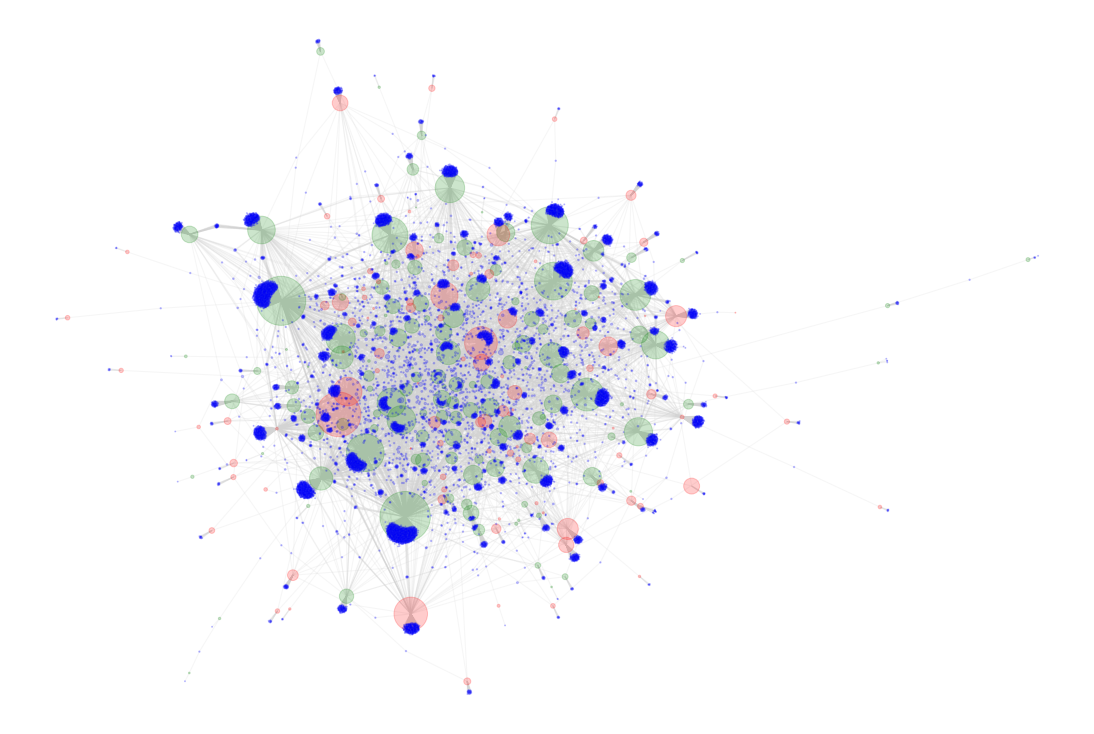

In [80]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING

from fa2 import ForceAtlas2

plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=10.0,
    
    # Log
    verbose=True
)

positions = forceatlas3.forceatlas2_networkx_layout(G00, pos=None, iterations=500)

# Generate sizes based on node centrality
node_sizes = [v for (n,v) in G00.nodes.data('nrReviews')]
#node_sizes = list(nx.degree_centrality(G).values())
#node_sizes = [round(num,3) for num in node_sizes]
#node_sizes = [num*5000 for num in node_sizes]

# 
nodes_colors = []
for (n,v) in G00.nodes.data('kind'):
    if (v=='Pizzeria'):
        nodes_colors.append('red')
    elif (v=='Restaurant'):
        nodes_colors.append('green')
    else:
        nodes_colors.append('blue')

# Generate the graph
nx.draw(G00, positions, with_labels = False, node_size = node_sizes, 
        node_color = nodes_colors, edge_color = 'lightgray', alpha=0.2);

The graph above shows the interaction between all the restaurants in the dataset (both pizzerias and non pizzerias) along with the users that have rated each place. Pizzerias are colored red, non-pizzerias green and the users are colored in blue. 

The network shows that the majority of the reviewers have only rated a single restaurant, and that causes the clusters of reviewers close to each restaurant. This is not surprising as the dataset only contained English reviews, which are usually turists, as natives tend to write their reviews in Danish. But there are some cases where reviewers have rated multiple locations. For instances, there are two green (non-pizzerias) in the top left, where we can see a small cluster of reviewers in the are between them. 

### Network of only Pizzerias
Lets now create a similar network but only displaying the Pizzerias and the users that have rated them.

In [97]:
# Create new graph - ONLY PIZZERIAS
G2 = nx.Graph()

# Add each restaurant and 
for idx, r in pizzeria.iterrows():
    
    nr_reviews = r.nrReviews #pizza[pizza.storeName == r].nrReviews.reset_index()['nrReviews'][0]

    G2.add_node(r.storeName, kind='Pizzeria', nrReviews = nr_reviews, no_followers = 0, no_upvotes = 0, location = r.area)
    
# Find all reviews of a pizzeria
reviews['pizzeria'] = reviews.apply(lambda x: 1 if x.storeName in set(pizzeria_list) else 0, axis=1)

# Filter those out
pizza_reviews = reviews[reviews.pizzeria == 1]

reviewer_list = list(pizza_reviews['reviewerUsername'].unique())

nr_reviews = pizza_reviews.groupby('reviewerUsername').agg('count')['storeName']        
# Add all the reviewers as reviewers
for r in reviewer_list:
    nr = nr_reviews[r]
    
    no_followers = 0
    no_upvotes = 0
    location = ''
    
    # if we find the user info
    if len(users[users.username==r] != 0):
        no_followers = users[users.username==r].nrFollowers.item()
        no_upvotes = users[users.username==r].nrUpvotes.item()
        location = users[users.username==r].location.item()
        
    G2.add_node(r, kind='Reviewer', nrReviews = nr, no_followers = no_followers, no_upvotes = no_upvotes, location=location)

# Add all the edges between restaurants and reviewers, only those in the sets
for idx, row in pizza_reviews.iterrows():
    G2.add_edge(row.storeName, row.reviewerUsername, rating=row.rating, rating_sentiment=row.sentiment)
    
# https://stackoverflow.com/questions/8576737/how-to-only-keep-nodes-in-networkx-graph-with-2-outgoing-edges-or-0-outgoing-ed
# Remove leaves (that only have degree=1) - for plotting - remove reviewers that have only given a single review

deg = G2.degree()
to_remove = [n for (n,d) in G2.degree() if d <= 1]

G2.remove_nodes_from(to_remove)

Gcc = sorted(nx.connected_components(G2), key=len, reverse=True)
G0 = G2.subgraph(Gcc[0])

100%|██████████| 20000/20000 [00:47<00:00, 418.49it/s]

BarnesHut Approximation  took  9.60  seconds
Repulsion forces  took  35.14  seconds
Gravitational forces  took  0.26  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  1.30  seconds


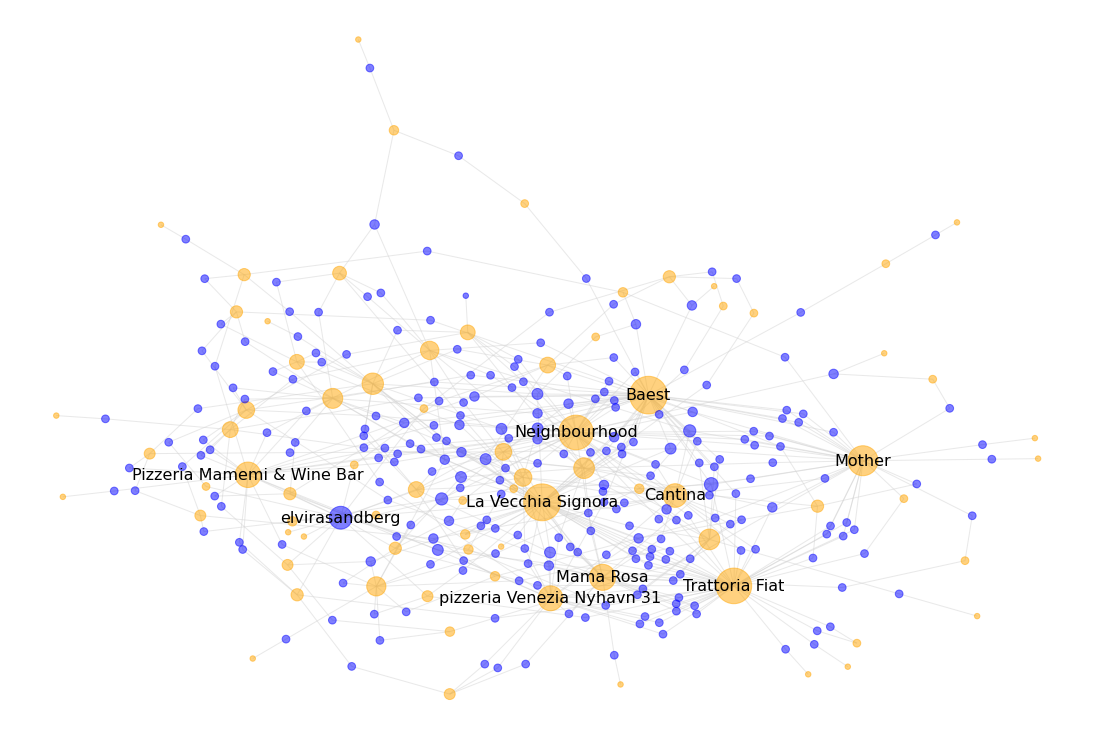

In [117]:
# Lets plot the pizza restaurants and the users that have rated at least two places in a single plot

plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=10.0,
    strongGravityMode=False,
    gravity=10.0,
    
    # Log
    verbose=True
)

positions = forceatlas3.forceatlas2_networkx_layout(G0, pos=None, iterations=20000)

# Generate sizes based on node centrality
#node_sizes = [v for (n,v) in G0.nodes.data('nrReviews')]
node_sizes = list(nx.degree_centrality(G0).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*10000 for num in node_sizes]

# 
nodes_colors = []
for (n,v) in G0.nodes.data('kind'):
    if (v=='Pizzeria'):
        nodes_colors.append('orange')
    else:
        nodes_colors.append('blue')

# Generate the graph
nx.draw(G0, positions, with_labels = False, node_size = node_sizes, 
        node_color = nodes_colors, edge_color = 'lightgray', alpha=0.5);


# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G0).items(), key = itemgetter(1), reverse = True)[:15])
top_nodes = list(nodes.keys())

# Generate the labels
labels = {}
for node in G0.nodes():
    if node in top_nodes[:10]:
    #if G0.nodes()[node]['kind']=='Pizzeria':
        #set the node name as the key and the label as its value
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G0, positions, labels, font_size=16, font_color='black');

The pizzerias and their reviewers are plotted on a graph, only showing the greatest connected component (GCC) in order for the plot to show up clearly. The restaurants are in orange and the reviewers are in blue. (hope the distinction is clear for the color blind) The names of the top 10 nodes based on degree centrality are shown. Those include 9 pizzerias and 1 reviewer. 
The figure shows that there are certain clusters of users that rate the mainly the most popular restaurants.
The graph also shows that the user "elvirasandberg" has rated a lot of restaurants, as this users degree centrality is very high. This indicates that she is a big pizzeria fan.

In [118]:
len(pizza_reviews[pizza_reviews.reviewerUsername=='elvirasandberg'])

17

As can be seen from the fact that she has rated a total of 17 of the pizzerias in Copenhagen.

### Community detection in the network

Lets try to apply community detection algorithms to the network, and see if the users and pizzerias can be groupped together into different communities. After applying the community detection algorithm on the dataset, there are 12 communities detected.

In [119]:
# inspo: https://deepnote.com/@deepnote/An-Introduction-to-Social-Network-Analysis-with-NetworkX-Two-Factions-of-a-Karate-Club-w4wQvz-rTpeKZpx8DrlyrQ
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# perform the community detection
c = list(greedy_modularity_communities(G0))

# Let's find out how many communities we detected
print(len(c))

12


Now a small helper function is defined to find the community number of a node.

In [120]:
# Define a small helper function to define community number
def find_community_no(node_name):
    for i in range(len(c)):
        if node_name in c[i]:
            return i

Then we plot the network, where each community is represented by a specific color.

In [121]:
# From an old project of mine
# https://nbviewer.jupyter.org/github/kristin14/hello-world/blob/master/Explainer_notebook_final.ipynb
import matplotlib as mtpl

# Define colours for the plot
cmap = mtpl.cm.get_cmap('tab20', len(c))

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(mtpl.colors.rgb2hex(rgb))

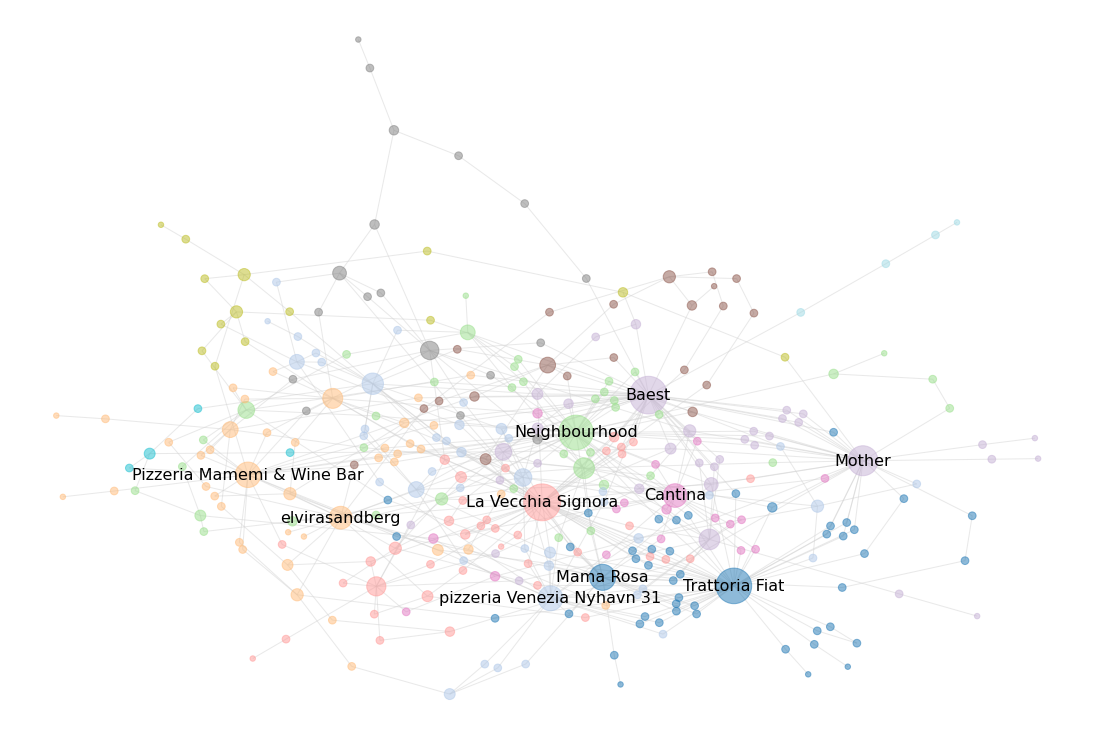

In [122]:
# Lets plot the pizza restaurants and the users that have rated at least two places in a single plot

plt.figure(figsize=(15,10))

# Generate sizes based on node centrality
#node_sizes = [v for (n,v) in G0.nodes.data('nrReviews')]
node_sizes = list(nx.degree_centrality(G0).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*10000 for num in node_sizes]

nodes_colors = []

for (n,v) in G0.nodes.data('kind'):
    #if (v=='Pizzeria'):
    #    nodes_colors.append('black')
    #else:
    nodes_colors.append(colors[find_community_no(n)])

# Generate the graph
nx.draw(G0, positions, with_labels = False, node_size = node_sizes, 
        node_color = nodes_colors, edge_color = 'lightgray', alpha=0.5);
    
    
# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G0).items(), key = itemgetter(1), reverse = True)[:15])
top_nodes = list(nodes.keys())

# Generate the labels
labels = {}
for node in G0.nodes():
    if node in top_nodes[:10]:
    #if G0.nodes()[node]['kind']=='Pizzeria':
        #set the node name as the key and the label as its value
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G0, positions, labels, font_size=16, font_color='black');

From the graph above we can see the different communities represented by different colours (sorry I know you are color blind but I don't know how to present this in a different way 😬). It groups restaurants and users together based on similarities in the network. From the above we can see that the purple community consists of Bæst, Mother and the users close to them. The blue community consists of Trattoria Fiat, Mama Rosa and the reviewers close to them. Neihgbourhood is located in the center in green, with users spreading out through the network. The orange community consists of Pizzeria Mamemi & Wine Bar along with users such as elvirasandberg. We can see that the nodes location in some instances seem to correspond to neighbourhoods, with the orange, red and blue neighbourhoods being particularly clear in the figure. 

### The most influential reviewers

So can we use this information to determine which reviewers are most influential, to figure out which users should be invited to the grand opening of our client's new pizza place?

100%|██████████| 1000/1000 [00:02<00:00, 408.39it/s]


BarnesHut Approximation  took  0.54  seconds
Repulsion forces  took  1.76  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


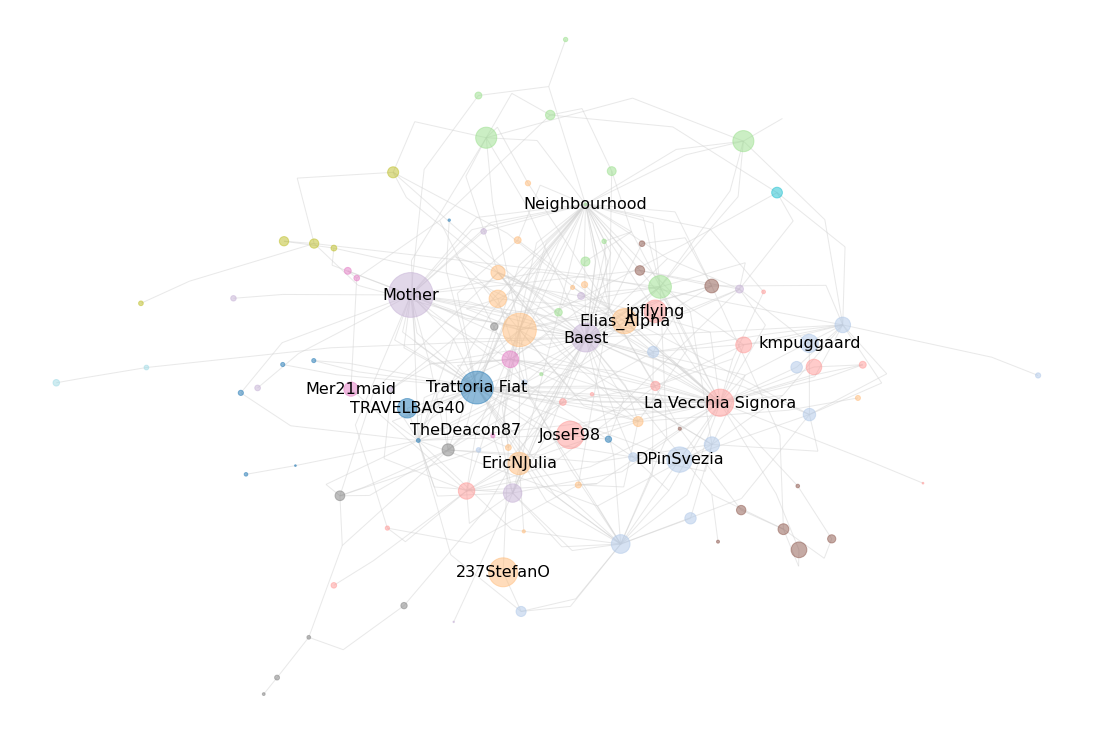

In [126]:
# Lets plot the pizza restaurants and the users that have rated at least two places in a single plot

plt.figure(figsize=(15,10))

forceatlas4 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=10.0,
    strongGravityMode=False,
    gravity=10.0,
    
    # Log
    verbose=True
)

positions2 = forceatlas4.forceatlas2_networkx_layout(G0, pos=None, iterations=1000)

# Generate sizes based on node centrality
#node_sizes = [v for (n,v) in G0.nodes.data('nrReviews')]
#node_sizes = list(nx.degree_centrality(G0).values())
#node_sizes = [round(num,3) for num in node_sizes]
#node_sizes = [num*10000 for num in node_sizes]

node_sizes = []

for n in G0.nodes(data=True):
    if n[1]['kind']=='Pizzeria':
        node_sizes.append(n[1]['nrReviews'])
    else:
        node_sizes.append(n[1]['no_followers']*n[1]['no_upvotes'])

nodes_colors = []

for (n,v) in G0.nodes.data('kind'):
    #if (v=='Pizzeria'):
    #    nodes_colors.append('red')
    #else:
    nodes_colors.append(colors[find_community_no(n)])

# Generate the graph
nx.draw(G0, positions2, with_labels = False, node_size = node_sizes, 
        node_color = nodes_colors, edge_color = 'lightgray', alpha=0.5);
    
    
# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G0).items(), key = itemgetter(1), reverse = True)[:15])
top_nodes = list(nodes.keys())

# Find the biggest reviewers based on no_followers
nodes_r = dict(sorted(G0.nodes.data('no_followers'), key = itemgetter(1), reverse = True)[:10])
top_nodes_r = list(nodes_r.keys())

# Find the biggest reviewers based on no_followers
nodes_u = dict(sorted(G0.nodes.data('no_upvotes'), key = itemgetter(1), reverse = True)[:10])
top_nodes_u = list(nodes_u.keys())

# Generate the labels
labels = {}
for node in G0.nodes():
    if (node in top_nodes[:5]) or (node in top_nodes_r[:5]) or (node in top_nodes_u[:5]):
        #set the node name as the key and the label as its value
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G0, positions2, labels, font_size=16, font_color='black');

In the graph above, we plot the network of restaurants and users, with the colors representing the community of each. The size of the nodes correspond to the number of reviews for the resturants, but for the users the size is represented by the number of followers they have multiplied by the number of upvotes each has gotten. Some of the biggest restaurants (with respect to degree centrality) are printed along with the most influential users.
Lets examine the most influencial users more by printing out their information.

In [90]:
for node in G0.nodes(data=True):
    if ((node[0] in top_nodes_r[:5]) or (node[0] in top_nodes_u[:5]) or node[0]=='elvirasandberg'):
        print("User: " +  node[0].rjust(12) + " with # followers: " + str(node[1]['no_followers']) + " and # upvotes: " + str(node[1]['no_upvotes']))
        print("# of pizza reviews: " + str(node[1]['nrReviews']))
        print("Location: " + node[1]['location'])
        print("Community: " + str(find_community_no(node[0])) + "\n")     

User: elvirasandberg with # followers: 0 and # upvotes: 0
# of pizza reviews: 17
Location: 
Community: 2

User:   EricNJulia with # followers: 3 and # upvotes: 168
# of pizza reviews: 2
Location: United Kingdom
Community: 2

User:     jpflying with # followers: 5 and # upvotes: 101
# of pizza reviews: 4
Location: Timaru, New Zealand
Community: 4

User:    Mer21maid with # followers: 1 and # upvotes: 204
# of pizza reviews: 2
Location: Copenhagen
Community: 7

User:  TRAVELBAG40 with # followers: 2 and # upvotes: 190
# of pizza reviews: 2
Location: Barnsley, United Kingdom
Community: 0

User:  TheDeacon87 with # followers: 0 and # upvotes: 325
# of pizza reviews: 2
Location: Great Falls, Virginia
Community: 0

User:   DPinSvezia with # followers: 5 and # upvotes: 129
# of pizza reviews: 4
Location: Kavlinge, Sweden
Community: 1

User:   kmpuggaard with # followers: 3 and # upvotes: 110
# of pizza reviews: 2
Location: Copenhagen, Denmark
Community: 1

User:   237StefanO with # followers:

From the above we can see that the most "influential" reviewers are not really that influential in the graph, since they have few followers, even if they have decent number of upvotes. Since this is only based on reviews in English, this is not surprising, as the majoritiy of the reviews could easily be in Danish in Denmark. However our recommendation would be to invite those users that live in Copenhagen, **Mer21maid** and **kmpuggaard**. Along with **JoseF98** who lives in Malmö, Sweden. By doing that we are inviting three users, that are all a part of a different communities (7, 1 and 2), so their influence will be maximized, as they did not have enough in common to be classified as part of the same community. Since **elvirasandberg** has also rated 17 pizza restaurants, it might be a good idea to extend an invite, even if the user has no upvotes or followers, it's also highly likely given the number of reviews that the user lives in the area, even if not specified.

### The effect of inviting four selected users to try the new place
So what effect might we have by inviting these four selected users to the grand opening. 
These users are apart of three seperate communities. Communitites 1, 2 and 7. 
Lets start by looking at which places and users are apart of this community

In [91]:
# Genereate our invite list
invite_list = set(['Mer21maid', 'kmpuggaard', '237StefanO', 'elvirasandberg'])

100%|██████████| 2000/2000 [00:00<00:00, 3052.54it/s]


BarnesHut Approximation  took  0.11  seconds
Repulsion forces  took  0.45  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


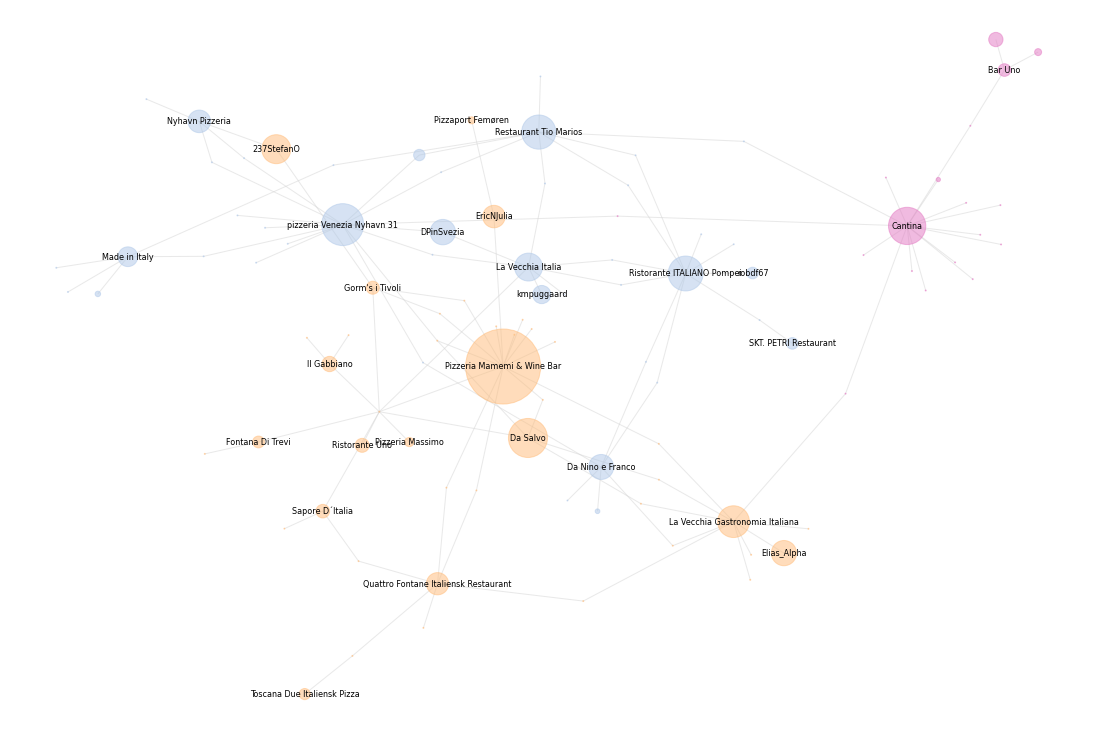

In [134]:
# Lets remove all restaurants and nodes that are not apart of these three communities
to_remove = [n for n in G0.nodes() if find_community_no(n) not in set([1,2,7])]

G_inf2 = nx.Graph(G0)

G_inf2.remove_nodes_from(to_remove)

Gcc = sorted(nx.connected_components(G_inf2), key=len, reverse=True)
G_inf = G_inf2.subgraph(Gcc[0])

# Create a new plot

plt.figure(figsize=(15,10))


forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=10.0,
    strongGravityMode=False,
    gravity=10.0,
    
    # Log
    verbose=True
)

positions = forceatlas3.forceatlas2_networkx_layout(G_inf, pos=None, iterations=2000)

# Generate sizes based on node centrality
#node_sizes = [v for (n,v) in G0.nodes.data('nrReviews')]
#node_sizes = list(nx.degree_centrality(G0).values())
#node_sizes = [round(num,3) for num in node_sizes]
#node_sizes = [num*10000 for num in node_sizes]

node_sizes = []

for n in G_inf.nodes(data=True):
    # if the nodes are not apart of community 7, 1 or 2, we want their size to be very small
    if find_community_no(n[0]) in set([7,1,2]):
        if n[1]['kind']=='Pizzeria':
            node_sizes.append(n[1]['nrReviews']*5)
        else:
            node_sizes.append(n[1]['no_followers']*n[1]['no_upvotes']+1)
    else:
        node_sizes.append(1)

nodes_colors = []

for (n,v) in G_inf.nodes.data('kind'):
    #if (v=='Pizzeria'):
    #    nodes_colors.append('red')
    #else:
    nodes_colors.append(colors[find_community_no(n)])

# Generate the graph
nx.draw(G_inf, positions, with_labels = False, node_size = node_sizes, 
        node_color = nodes_colors, edge_color = 'lightgray', alpha=0.5);
    
    
# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G_inf).items(), key = itemgetter(1), reverse = True)[:20])
top_nodes = list(nodes.keys())

# Find the biggest reviewers based on no_followers
nodes_r = dict(sorted(G_inf.nodes.data('no_followers'), key = itemgetter(1), reverse = True)[:20])
top_nodes_r = list(nodes_r.keys())

# Find the biggest reviewers based on no_followers
nodes_u = dict(sorted(G_inf.nodes.data('no_upvotes'), key = itemgetter(1), reverse = True)[:20])
top_nodes_u = list(nodes_u.keys())

# Generate the labels
labels = {}
for node in G_inf.nodes(data=True):
    #if ((node[0] in invite_list) or (node[1]['kind']=='Pizzeria' and find_community_no(node[0]) in set([7,1,2]) and node[1]['nrReviews']>50)):
        #set the node name as the key and the label as its value
    if ((node[1]['no_followers']>1) or (node[1]['kind']=='Pizzeria')):
        labels[node[0]] = node[0]

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G_inf, positions, labels, font_size=8, font_color='black');


From the above we can see that the network mostly consists of restaurants (bigger nodes) along with their reviewers. Some reviewers have no influence and no upvotes, and those are shown by tiny nodes with no labels. 
By inviting those four users we have the potential to influence these 3 communities, as other users within the communities might be influeced by our chosen users. The main player in the network is **Pizzeria Mamemi & Wine Bar** as we have previously seen is one of the most popular pizzerias in the market. Since our recommendation is to open up a place in Vesterbro, lets examine which places in Vesterbro are apart of this network.

In [93]:
# Generate a new column to indicate the community the restaurant is a part of.
pizzeria['community'] = pizzeria.storeName.apply(find_community_no);

<ipython-input-93-13965cf38a90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizzeria['community'] = pizzeria.storeName.apply(find_community_no);


In [130]:
# Check out which restaurants are a part of these communities and are also located in
pizzeria[((pizzeria.community==1) | (pizzeria.community==2)| (pizzeria.community==7)) & (pizzeria.area =='Vesterbro-Kongens Enghave')][['storeName', 'storeAddress', 'avgRating', 'nrReviews', 'priceCategory', 'area', 'sentiment', 'nrReviews_per_day_EN', 'mainly_pizza', 'community']]

storeName                               storeAddress  \
3    Pizzeria Mamemi & Wine Bar    Mysundegade 28, Copenhagen 1668 Denmark   
143            Fontana Di Trevi  Vesterbrogade 87, Copenhagen 1620 Denmark   

     avgRating  nrReviews  priceCategory                       area  \
3          5.0       1126            1.0  Vesterbro-Kongens Enghave   
143        4.0         28            2.5  Vesterbro-Kongens Enghave   

     sentiment  nrReviews_per_day_EN  mainly_pizza  community  
3     0.851159              0.210775             1        2.0  
143   0.732554              0.006529             1        2.0

These two pizzerias would be the main players effect if our approach would prove successful. They have different profiles, one extremely popular while the other is less so. The popular place has a very low price category, so we might decide not to position ourselves to closly to them pricewise, as we have seen previously that the areas average price category is way higher. 

>**Conclusions:** It's difficult to use such sparse networks to really capture the true influence of users to find out which ones would be best to invite. The restaurants and reviews were split up into 12 communities, each with some similarities between its' nodes and dissimilarities to the nodes in other communities. From those 12 communities we detected four users that should be invited to the grand opening, coming from three communities. These results are all dependant on the English reviews, but it would be good to extend this analysis to the Danish reviews, in order to hopefully get a more dense network, or at least a network with more influential nodes.

<a id='conclusions'></a>
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
# Conclusions and Discussions

Lets circle back to the market questions we had to answer in order to be able to answer the business question: 

>**Where should we open up a new Pizza place, who should we invite to the opening and what should we keep in mind?**

* **Who are the players in the market? Are they only Pizzerias?**
    * From the results in [3.1 Cousine Types](#cousine) we saw that around half of the restaurants in the final dataset were specially categorized as pizza places. So the market is much bigger than indicated only by the Cousine Type of Pizza. So it's important to keep in mind that your main competitors might end up not being other pizzerias, but simply restaurants that offer pizzas on the menu. The pizzerias are more popular than the other restaurants, but have been reviewed fewer times. They also tend to be cheaper than the other restaurants. They have a higher average rating but a lower average sentiment.
    
* **What are the popular places doing differently?**
    * From the results in [3.8 TF-IDF of popular pizzerias - What matters for popularity?](#popular_wordcloud) we saw that the most popular pizzerias are either located in Indre By or Vesterbro. All of the top 5 most popular places make sure to distinquish themselves from their competitors by offering something unique. In some cases it can be great cocktails, in others great wine, or a unique outdoor area. Some put more emphasis on the materials used being organic or even homemade. But it is clear that each one made sure to state clearly what they wanted to be best known for. Therefore it is very important for the client to create a clear message for the reviewers to understand what makes this new pizza place special, compared to all the other players in the area. Then they need to make sure that the branding of the place represents what makes them unique in the market.

* **Where are the restaurants located?**
    * From the results in [3.2 Where are the pizza restaurants located?](#pizza_loc) we saw that the distribution of both pizzerias and restaurants that offer pizzas, is mainly focused around the center of Copenhagen. The majority is in Indre By, and close to the edges of the neighbouring areas, mainly, Vesterbro, Nørrebro and Østerbro. There seem to be quite a few designated pizza places in Bispebjerg, compared to the other areas that are further from the center, that usually only have a single one, or just restaurants that offer pizzas. 

* **How has the market developed?**
    * As showed in [3.4 Evolution of distribution of pizza places](#heatmap) ost of the restaurants are and have been focused around the center. Some restaurants further from the center pop up every now and then, but it seems that many of them have closed down in 2020, or simply cater more towards locals instead of turists, which would explain why they are less prominent in the dataset. The business for restaurants offering pizzas still seems to be pretty thriving, given the number of those places. But these places took a major hit in COVID, which can partly be explained by the lockdown in Denmark, which only allowed the places to offer take-away. Another reason for a lack of restaurant reviews in 2021, is that the dataset only contains English reviews, but because of Covid, the majority of customers during this periods, must have been Danish, and their reviews would most likely be written in Danish.
    * This was further analyzed in [3.6 Restaurant count development](#density_development) and the results showed that the pizza market has expanded considerably with Indre By leading the way and Vesterbro following closely behind. The market was expanding rapidly from 2007-2017, but after that there is a decline in the slope and in some cases there are declines in the number of open pizza places each year. The industry took a big hit when because of COVID starting in 2020. However there was already a decline before COVID, because the restaurants that were open at the start of 2020 count as having been open the entire year of 2020. But because of the market condititions and uncertainty there might have been fewer new places opening up, than usually. Given that the financing of the client's new Pizza place is secure, there are definately some opportunities in the market now, with there being fewer competitors than normally.

* **Where should you open up a pizza place?**
    * As showed in [3.5 Restaurant density](#density) the density of restaurants is by far highest in Indre By both given area(m^2) and population. Vesterbro and Nørrebro come in second and third place. A further analysis in [3.3 Differences between areas (neighbourhoods)](#diff_areas) showed that the different areas of Copenhagen display different characteristics, and depending on what type of Pizzeria the clients want to open the recommendations could be different. However as a general guideline we would receommend looking first at opening a restaurant in **Vesterbro**. 
    * >**Vesterbro** Has the lowest average rating, the second lowest sentiment, but is still very popular. It is the area with by far the lowest ratio of Pizzerias, while still having a high number of restaurants. It's less expensive than Indre By and Østerbro, but way more expensive than Nørrebro. 
    * The client is interested in opening up a new Pizza place. If this place would be positioned in Vesterbro, then it would be surrounded mainly by restaurants that serve pizzas but are not classified as Pizzeries. As shown in [3.1 Cousine Types](#cousine) the popularity of pizzerias is much higher than the popularity of the other types of restaurants, so we would be positioning ourselves in a really popular area, that has a low ratio of pizzerias, low average scores and sentiment values. By opening up a great new pizza place that would generate a high sentimental value and average rating, the place would stick out from the average crowd of other restaurants. We would also be able to position ourselves in a pretty high Price Category, but would have the option of offering cheaper food, in hopes of the sentiment and reviews being higher, given that the food is a great value for the price. 
    
* **Who should you invite to the opening of the new pizza place?**
    * The network analysis in [3.9 Network analysis](#network) concluded that it's difficult to use such sparse networks to really capture the true influence of users to find out which ones would be best to invite. The restaurants and reviews were split up into 12 communities, each with some similarities between its' nodes and dissimilarities to the nodes in other communities. From those 12 communities we detected four users that should be invited to the grand opening, coming from three communities. All those users live in close proximity to Copenhagen. The list is **Mer21maid**, **kmpuggaard**, **JoseF98** and **elvirasandberg**.
    * These results are all dependant on the English reviews, but it would be good to extend this analysis to the Danish reviews, in order to hopefully get a more dense network, or at least a network with more influential nodes. The list of reviewers that should be invited giben the English review network are: 

### Where should we open up a new Pizza place, who should we invite to the opening and what should we keep in mind?

>**Summary:** The pizza market consists of much more than only pizzerias. The market has been expanding until 2017 but been in some decline the last few years. There are oppurtinites in the market now after COVID and the best area to open up a designated pizzeria is estimated to be Vesterbro. Four users should be invited to the opening, **Mer21maid**, **kmpuggaard**, **JoseF98** and **elvirasandberg**. The clients need to distinguish themselves from other market players, by coming up with something unique to offer, either in food or experience. 

### What could be improved
* Would have needed to have a special ID for each restaurant, so that could link review and restaurant when there are more than one restaurant with the same name.
* The dataset only contained information about the reviews that were in English, seeing as the consultation was performed in English and all the main text analysis packages perform best in English. As the market also consists very much of locals, it might have been good to inlude Danish reviews as well. 
* Related to the last note, it was difficult to find truly influencial users in the network, as the network consists mostly of turists visiting the area. In reality it might have been better to find the most influential Danish reviewers, as it is more likely that they are followed by other Danes, and their followers could better act on the information, if they are located in the capital area.


### Thank you for reading all the way to the end 🥳
![img](https://1.bp.blogspot.com/-VPl0cjQLZBU/XtfkoWscgXI/AAAAAAAACrI/6xgMHrmYiJEGSY5LvvR_VKtrIUgjopQogCLcBGAsYHQ/s640/Thank-You-Gif.gif)